In [1]:
import glob
import os
import pickle
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# credits and installation https://github.com/njchiang/tikhonov.git
from tikhonov.TikhonovRegression import Tikhonov
from sklearn.linear_model import LinearRegression

from scipy import interpolate as interp

import geopandas

In [2]:
def set_plot_fontsizes(SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE):
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# load the latest computed dataset

In [3]:
COMPUTED_PATH = '../../data/computed/worldwide'
WORLDWIDE_BASE_PREFIX = 'worldwide_base_'
METADATA_BASE_NAME = 'metadata_{}.pickle'
WORLDWIDE_PREPROC_NAME = 'worldwide_preprocessing_{}.pickle'

# images
IMAGES_PATH = '../../images/worldwide'
MAX_NEW_CASES = 'worldwide_max_new_cases_{}.png'
TOTAL_CASES = 'worldwide_total_cases_{}.png'

In [4]:
DATASET_COMPUTED_FILENAME = os.path.basename(
    sorted(
        glob.glob(os.path.join(COMPUTED_PATH, WORLDWIDE_BASE_PREFIX + '*'))
    )[-1]
)

DATA_DATE = os.path.splitext(DATASET_COMPUTED_FILENAME)[0].replace(WORLDWIDE_BASE_PREFIX, '')

In [5]:
print('DATASET_COMPUTED_FILENAME: {}'.format(DATASET_COMPUTED_FILENAME))
print('DATA_DATE: {}'.format(DATA_DATE))

DATASET_COMPUTED_FILENAME: worldwide_base_2020-12-15.pickle
DATA_DATE: 2020-12-15


In [6]:
preprocessing = pd.read_pickle(os.path.join(COMPUTED_PATH, DATASET_COMPUTED_FILENAME))

In [7]:
preprocessing[preprocessing.index.get_level_values(0)!='Afghanistan']

retail_and_recreation_percent_change_from_baseline  \
country_region province_state date                                                             
Angola         NaN            2020-02-15                                                3.0    
                              2020-02-16                                               -4.0    
                              2020-02-17                                               -6.0    
                              2020-02-18                                               -3.0    
                              2020-02-19                                              -10.0    
...                                                                                     ...    
Zimbabwe       NaN            2020-12-11                                               12.0    
                              2020-12-12                                               12.0    
                              2020-12-13                                               11.0    
                              2020-12-14                                                8.0    
                              2020-12-15                                               10.0    

                                          grocery_and_pharmacy_percent_change_from_baseline  \
country_region province_state date                                                            
Angola         NaN            2020-02-15                                               -2.0   
                              2020-02-16                                                0.0   
                              2020-02-17                                               -4.0   
                              2020-02-18                                               -4.0   
                              2020-02-19                                              -12.0   
...                                                                                     ...   
Zimbabwe       NaN            2020-12-11                                               28.0   
                              2020-12-12                                               26.0   
                              2020-12-13                                               23.0   
                              2020-12-14                                               20.0   
                              2020-12-15                                               27.0   

                                          parks_percent_change_from_baseline  \
country_region province_state date                                             
Angola         NaN            2020-02-15                                 7.0   
                              2020-02-16                               -11.0   
                              2020-02-17                                 2.0   
                              2020-02-18                                -4.0   
                              2020-02-19                                -3.0   
...                                                                      ...   
Zimbabwe       NaN            2020-12-11                                29.0   
                              2020-12-12                                33.0   
                              2020-12-13                                41.0   
                              2020-12-14                                29.0   
                              2020-12-15                                28.0   

                                          transit_stations_percent_change_from_baseline  \
country_region province_state date                                                        
Angola         NaN            2020-02-15                                            3.0   
                              2020-02-16                                            1.0   
                              2020-02-17                                           -3.0   
                              2020-02-18                     

In [8]:
TIMESTEPS = len(preprocessing.index.get_level_values('date').unique())

In [9]:
preprocessing.interpolate(inplace=True)
assert(len(preprocessing[preprocessing.isnull().any(axis=1)].index.droplevel('date').unique())==0)

In [10]:
TIMESTEPS

305

In [11]:
preprocessing.shape

(79523, 8)

## add a combined key column

Merge the the two components of the multiindex:
- country_region
- province_state

into a single column country_state, as the concat of the two previous

In [12]:
preprocessing['country_state'] = list(map(
    lambda t: t[0] + ('' if t[1] is np.nan else ' - ' + t[1]),
    zip(
        preprocessing.index.get_level_values('country_region'), 
        preprocessing.index.get_level_values('province_state')
    )
))

# Smoothing

In [13]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [14]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [15]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [16]:
smoothing_map = {
    'retail_and_recreation_percent_change_from_baseline': {'func': smooth_data, 'ALPHA': 100., 'postfix': '_smoothed'},
    'grocery_and_pharmacy_percent_change_from_baseline': {'func': smooth_data, 'ALPHA': 100., 'postfix': '_smoothed'},
    'parks_percent_change_from_baseline': {'func': smooth_data, 'ALPHA': 100., 'postfix': '_smoothed'},
    'transit_stations_percent_change_from_baseline': {'func': smooth_data, 'ALPHA': 100., 'postfix': '_smoothed'},
    'workplaces_percent_change_from_baseline': {'func': smooth_data, 'ALPHA': 100., 'postfix': '_smoothed'},
    'residential_percent_change_from_baseline': {'func': smooth_data, 'ALPHA': 100., 'postfix': '_smoothed'},
    'confirmed': {'func': smooth_differentiate, 'ALPHA': 100., 'postfix': '_new_smoothed'},
    'deaths': {'func': smooth_differentiate, 'ALPHA': 100., 'postfix': '_new_smoothed'}
}

In [17]:
inconsistencies = []
counry_states = preprocessing.index.droplevel('date').unique().copy()
cols = smoothing_map.keys()

for idx in counry_states:
    print('\n{} - {}'.format(*idx))
    
    for col in cols:
        print('   * {} - '.format(col), end='')
        sm = smoothing_map[col]
        try:
            series = sm['func'](preprocessing.loc[idx, col], INTEGRAL_MATRIX, GAMMA, sm['ALPHA'])
            preprocessing.loc[idx, col+sm['postfix']] = series
        except ValueError:
            inconsistencies.append(idx)
    


Afghanistan - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Angola - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8917115537549888
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8205583856080928
   * parks_percent_change_from_baseline - TIC R2: 0.892031367420998
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact per

TIC R2: 0.8860121864732631
   * workplaces_percent_change_from_baseline - TIC R2: 0.5312217297163442
   * residential_percent_change_from_baseline - TIC R2: 0.869955652226779
   * confirmed - TIC R2: 0.9999840806941463
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999401720170303

Antigua and Barbuda - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Argentina - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9495507232312754
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7215841905310036
   * parks_percent_change_from_baseline - TIC R2: 0.9730912213277336
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9216725567723331
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
 

TIC R2: 0.8024450772401945
   * residential_percent_change_from_baseline - TIC R2: 0.9377155297190095
   * confirmed - TIC R2: 0.9999933103145577
   * deaths - TIC R2: 0.9998925059244294

Australia - Australian Capital Territory
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9034642112408833
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7290414535906591
   * parks_percent_change_from_baseline - TIC R2: 0.32035903482904704
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9264572871623252
   * workplaces_percent_change_from_baseline - TIC R2: 0.7702423900720662
   * residential_percent_change_from_baseline - TIC R2: 0.7883654969682626
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9995667957842085
   * deaths - TIC R2: 0.9956584910718419

Australia - New South Wales
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9395054278640408
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7148059551561694
   * parks_percent_change_from_baseline - TIC R2: 0.548048330701363
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9158734810236762
   * workplaces_percent_change_from_baseline - TIC R2: 0.8343673930664189
   * residential_percent_change_from_baseline - TIC R2: 0.835757920430535
   * confirmed - TIC R2: 0.9999008817111443
   * deaths - TIC R2: 0.999575151689753

Australia - Northern Territory
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9479921634297408
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7677905567899334
   * parks_percent_change_from_baseline - TIC R2: 0.892834303485939
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8418801759869999
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5809409210643424
   * residential_percent_change_from_baseline - TIC R2: 0.8211375539440847
   * confirmed - TIC R2: 0.9986202713005855
   * deaths - TIC R2: 1.0

Australia - Queensland
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8862517268092628
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.4806405580440636
   * parks_percent_change_from_baseline - TIC R2: 0.7572930760275962
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9607701149131719
   * workplaces_percent_change_from_baseline - TIC R2: 0.8036085903933721
   * residential_percent_change_from_baseline - TIC R2: 0.8716609993641191
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999294387773584
   * deaths - TIC R2: 0.9963532540279895

Australia - South Australia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7858600584049599
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.4203216190244706
   * parks_percent_change_from_baseline - TIC R2: 0.5555463334429096
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.905717193140501
   * workplaces_percent_change_from_baseline - TIC R2: 0.6691139066826337
   * residential_percent_change_from_baseline - TIC R2: 0.8030347168545694
   * confirmed - TIC R2: 0.9996524975477716
   * deaths - TIC R2: 0.997301489005024

Australia - Tasmania
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9216390337251806
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7494832591383069
   * parks_percent_change_from_baseline - TIC R2: 0.8294312837878346
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9296756611946221
   * workplaces_percent_change_from_baseline - TIC R2: 0.7303243138861395
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9177175279030163
   * confirmed - TIC R2: 0.9997949101221072
   * deaths - TIC R2: 0.9992360826222225

Australia - Victoria
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9501828721232476
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8073239551958229
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5733667431733641
   * transit_stations_percent_change_from_baseline - TIC R2: 0.962866555907872
   * workplaces_percent_change_from_baseline - TIC R2: 0.7679410439386098
   * residential_percent_change_from_baseline - TIC R2: 0.8847365095792087
   * confirmed - TIC R2: 0.9999922232039367
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999452287038149

Australia - Western Australia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9087130692867484
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6866656834008276
   * parks_percent_change_from_baseline - TIC R2: 0.5426825304212038
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9134405493364828
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7195595078848812
   * residential_percent_change_from_baseline - TIC R2: 0.8855218823945253
   * confirmed - TIC R2: 0.9997575817805331
   * deaths - TIC R2: 0.9977455257808254

Austria - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9175291547750397
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.37158604828721453
   * parks_percent_change_from_baseline - TIC R2: 0.8196837777549488
   * transit_stations_percent_change_from_baseline - TIC R2: 0.938486561671544
   * workplaces_percent_change_from_baseline - TIC R2: 0.6645331160699295
   * residential_percent_change_from_baseline - TIC R2: 0.8406842724791286
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999747763920203
   * deaths - TIC R2: 0.9999440271268413

Bahrain - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.814709891680998
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6273560442281725
   * parks_percent_change_from_baseline - TIC R2: 0.6604860880936174
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.81119514999444
   * workplaces_percent_change_from_baseline - TIC R2: 0.723606218674578
   * residential_percent_change_from_baseline - TIC R2: 0.8840759390360219
   * confirmed - TIC R2: 0.9999974658959428
   * deaths - TIC R2: 0.9999592834877772

Bangladesh - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9792508402148428
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9640319971032181
   * parks_percent_change_from_baseline - TIC R2: 0.9455683167513825
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9813968699170815
   * workplaces_percent_change_from_baseline - TIC R2: 0.8875515315901603
   * residential_percent_change_from_baseline - TIC R2: 0.9478823974852577
   * confirmed - TIC R2: 0.9999983377428183
   * deaths - TIC R2: 0.9999974451409129

Barbados - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9261995535427595
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7707124981044329
   * parks_percent_change_from_baseline - TIC R2: 0.9423195031088172
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9321136233215298
   * workplaces_percent_change_from_baseline - TIC R2: 0.9124382439377745
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8741877026572876
   * confirmed - TIC R2: 0.9997860103832007
   * deaths - TIC R2: 0.9983311506930602

Belarus - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7131442304716586
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.47164170371699443
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8036322392980126
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7260320038921955
   * workplaces_percent_change_from_baseline - TIC R2: 0.5407790519226008
   * residential_percent_change_from_baseline - TIC R2: 0.6034921157413204
   * confirmed - TIC R2: 0.9999985976170107
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999959286820023

Belgium - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9136085460579344
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.4959472141498549
   * parks_percent_change_from_baseline - TIC R2: 0.8448303092538467
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9310949513788075
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5571167853802961
   * residential_percent_change_from_baseline - TIC R2: 0.8149077564758962
   * confirmed - TIC R2: 0.9999626068816176
   * deaths - TIC R2: 0.9999701252505919

Belize - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.89000400717515
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7918639116830976
   * parks_percent_change_from_baseline - TIC R2: 0.9060891737771484
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9467873049516585
   * workplaces_percent_change_from_baseline - TIC R2: 0.8012391673851539
   * residential_percent_change_from_baseline - TIC R2: 0.8411040747628261
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9993120580062932
   * deaths - TIC R2: 0.9995247038568358

Benin - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.842935285570557
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9596251522261567
   * parks_percent_change_from_baseline - TIC R2: 0.8963912889211411
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8339487366399645
   * workplaces_percent_change_from_baseline - TIC R2: 0.367162167545234
   * residential_percent_change_from_baseline - TIC R2: 0.7908186465436162
   * confirmed - TIC R2: 0.9997284325725648
   * deaths - TIC R2: 0.9995698715085148

Bolivia - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8804047051318626
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7670076561348596
   * parks_percent_change_from_baseline - TIC R2: 0.844388437047312
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8790479114543702
   * workplaces_percent_change_from_baseline - TIC R2: 0.9061174852699151

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_


   * residential_percent_change_from_baseline - TIC R2: 0.9412629247814627
   * confirmed - TIC R2: 0.9999953837922976
   * deaths - TIC R2: 0.9996527168964383

Bosnia and Herzegovina - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9622886265173931
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8406303799879176
   * parks_percent_change_from_baseline - TIC R2: 0.8804034935084935
   * transit_stations_percent_change_from_baseline - TIC R2: 0.946227794796742
   * workplaces_percent_change_from_baseline - TIC R2: 0.8797237641960275
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.916683976965079
   * confirmed - TIC R2: 0.9999747499472321
   * deaths - TIC R2: 0.999964744584826

Botswana - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9361724104124706
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9315633785461975
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9562889225901215
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9513786383064797
   * workplaces_percent_change_from_baseline - TIC R2: 0.7874178673411384
   * residential_percent_change_from_baseline - TIC R2: 0.9368756890314067
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9991660225635842
   * deaths - TIC R2: 0.9988865881555621

Brazil - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9271527191059417
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8018541902192362
   * parks_percent_change_from_baseline - TIC R2: 0.828429908533576
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9244800796702026
   * workplaces_percent_change_from_baseline - TIC R2: 0.7093847982629644
   * residential_percent_change_from_baseline - TIC R2: 0.8916777593271767
   * confirmed - TIC R2: 0.9999848864903984
   * deaths - TIC R2: 0.9999887978781001

Bulgaria - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.94767524926784
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.842678976592133
   * parks_percent_change_from_baseline - TIC R2: 0.8501925679450061
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9521121296707591
   * workplaces_percent_change_from_baseline - TIC R2: 0.5510051565083627
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.816391137149623
   * confirmed - TIC R2: 0.9999055315160085
   * deaths - TIC R2: 0.9998814293793648

Burkina Faso - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9464963318938888
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9624623771799289
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9590964318283901
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9438261707090934
   * workplaces_percent_change_from_baseline - TIC R2: 0.45974423470538806
   * residential_percent_change_from_baseline - TIC R2: 0.8772239694049558
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.

TIC R2: 0.999774461615845
   * deaths - TIC R2: 0.9996797879215913

Cabo Verde - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Cambodia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.955385877498723
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.882215848526292
   * parks_percent_change_from_baseline - TIC R2: 0.805352810593891
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return sel

TIC R2: 0.9507628347754306
   * workplaces_percent_change_from_baseline - TIC R2: 0.7131563206798306
   * residential_percent_change_from_baseline - TIC R2: 0.8521234787739678
   * confirmed - TIC R2: 0.9995042537515256
   * deaths - TIC R2: 1.0

Cameroon - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9233692406910237
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9020906524404884
   * parks_percent_change_from_baseline - TIC R2: 0.8974477770955513
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9667668166137645
   * workplaces_percent_change_from_baseline - TIC R2: 0.5105054060585439
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9042434345409435
   * confirmed - TIC R2: 0.9997523446437603
   * deaths - TIC R2: 0.999442694209351

Canada - Alberta
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9386289521000815
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6798987462123387
   * parks_percent_change_from_baseline - TIC R2: 0.8383255051436768
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8861137121810582
   * workplaces_percent_change_from_baseline - TIC R2: 0.5814644003517413
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6882178754558593
   * confirmed - TIC R2: 0.9999346944490518
   * deaths - TIC R2: 0.9998940966320198

Canada - British Columbia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9710149517358719
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8781733421893454
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7993492971913148
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9267291418333898
   * workplaces_percent_change_from_baseline - TIC R2: 0.6499434141570237
   * residential_percent_change_from_baseline - TIC R2: 0.7185127534151199
   * confirmed - TIC R2: 0.9996436960983132
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.999353978788385

Canada - Manitoba
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8693877650035
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5271409774108617
   * parks_percent_change_from_baseline - TIC R2: 0.9182568954504209
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9216854952737333
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5513481774103779
   * residential_percent_change_from_baseline - TIC R2: 0.6915187059565371
   * confirmed - TIC R2: 0.9999674091267524
   * deaths - TIC R2: 0.9999362187222819

Canada - New Brunswick
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7297109159628313
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.47563407834359817
   * parks_percent_change_from_baseline - TIC R2: 0.819600343319897
   * transit_stations_percent_change_from_baseline - TIC R2: 0.807753294284935

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_


   * workplaces_percent_change_from_baseline - TIC R2: 0.5132946139516108
   * residential_percent_change_from_baseline - TIC R2: 0.612710790230795
   * confirmed - TIC R2: 0.9998027783328991
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9969633357088341

Canada - Newfoundland and Labrador
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7989199777133078
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6380904520225483
   * parks_percent_change_from_baseline - TIC R2: 0.828675183899006
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8883764279831579
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5661893087483354
   * residential_percent_change_from_baseline - TIC R2: 0.6924470856748592
   * confirmed - TIC R2: 0.9995673720512074
   * deaths - TIC R2: 0.9942295083558975

Canada - Northwest Territories
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Canada - Nova Scotia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.6061519440944975
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.3668091415013863
   * parks_percent_change_from_baseline - TIC R2: 0.6884211844077177
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7762494681079416
   * workplaces_percent_change_from_baseline - TIC R2: 0.4927337548617211
   * residential_percent_change_from_baseline - TIC R2: 0.5471215897212542
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999061622902546
   * deaths - TIC R2: 0.999727961013463

Canada - Ontario
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9049578465828509
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.568739391895694
   * parks_percent_change_from_baseline - TIC R2: 0.8357951118233502
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8660643453738408
   * workplaces_percent_change_from_baseline - TIC R2: 0.5144308762611678
   * residential_percent_change_from_baseline - TIC R2: 0.63104149299592
   * confirmed - TIC R2: 0.9999895232424819
   * deaths - TIC R2: 0.9999618259276079

Canada - Prince Edward Island
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Canada - Quebec
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8831879451740153
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5836717899042796
   * parks_percent_change_from_baseline - TIC R2: 0.8579633379110257
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8785833914870163
   * workplaces_percent_change_from_baseline - TIC R2: 0.5560139684431218
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7317778788955064
   * confirmed - TIC R2: 0.99999178912613
   * deaths - TIC R2: 0.9999791088761257

Canada - Saskatchewan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8938831543754011
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6514513341802513
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9254749669598775
   * transit_stations_percent_change_from_baseline - TIC R2: 0.894168239574044
   * workplaces_percent_change_from_baseline - TIC R2: 0.5754037748576756
   * residential_percent_change_from_baseline - TIC R2: 0.7550011620347911
   * confirmed - TIC R2: 0.9999348130210803
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9989349889378479

Chile - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9196937889713966
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.824613966685843
   * parks_percent_change_from_baseline - TIC R2: 0.9286178746681233
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9543398184329068
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8015925888891566
   * residential_percent_change_from_baseline - TIC R2: 0.8954414642418549
   * confirmed - TIC R2: 0.9999871760381464
   * deaths - TIC R2: 0.999919245106282

China - Hong Kong
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8750084321099737
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8428107835177064
   * parks_percent_change_from_baseline - TIC R2: 0.6220329339163968
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7785845993716874
   * workplaces_percent_change_from_baseline - TIC R2: 0.4940285927254421
   * residential_percent_change_from_baseline - TIC R2: 0.6530874440640251
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999851488825688
   * deaths - TIC R2: 0.9998822538737724

Colombia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9436134484045613
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8971879408029735
   * parks_percent_change_from_baseline - TIC R2: 0.9245400498362594
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9475337322783777
   * workplaces_percent_change_from_baseline - TIC R2: 0.8034679352126817
   * residential_percent_change_from_baseline - TIC R2: 0.9091285511288226
   * confirmed - TIC R2: 0.9999977952301388
   * deaths - TIC R2: 0.9999964891981976

Costa Rica - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8218635155161315
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8537170121534403
   * parks_percent_change_from_baseline - TIC R2: 0.9000619882759484
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9286938020802935
   * workplaces_percent_change_from_baseline - TIC R2: 0.8648854911098073
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9160642715351002
   * confirmed - TIC R2: 0.9999711837639612
   * deaths - TIC R2: 0.9999475802381215

Cote d'Ivoire - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.907196233734431
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9283686236051886
   * parks_percent_change_from_baseline - TIC R2: 0.8955404094154322
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9044896526663957
   * workplaces_percent_change_from_baseline - TIC R2: 0.5046936810742974
   * residential_percent_change_from_baseline - TIC R2: 0.8721131813447702
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999870144230566
   * deaths - TIC R2: 0.9998938725485143

Croatia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9416241181286521
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6366695228903752
   * parks_percent_change_from_baseline - TIC R2: 0.9717947567779489
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8766995070637483
   * workplaces_percent_change_from_baseline - TIC R2: 0.6274378815622608
   * residential_percent_change_from_baseline - TIC R2: 0.830551572198865
   * confirmed - TIC R2: 0.9999304245981329
   * deaths - TIC R2: 0.9999792315629975

Czechia - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9329880169148835
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.2701716683273744
   * parks_percent_change_from_baseline - TIC R2: 0.8455336278633876
   * transit_stations_percent_change_from_baseline - TIC R2: 0.907120036790449
   * workplaces_percent_change_from_baseline - TIC R2: 0.4914717623384378
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7279434571130969
   * confirmed - TIC R2: 0.999953522335994
   * deaths - TIC R2: 0.9999754408566915

Denmark - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8135363923638401
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.46663222623612854
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8668268208698855
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9097790729569392
   * workplaces_percent_change_from_baseline - TIC R2: 0.5288157938802447
   * residential_percent_change_from_baseline - TIC R2: 0.7246594368878073
   * confirmed - TIC R2: 0.9999885020674841
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999683650654512

Dominican Republic - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.943910652780425
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9400134753380301
   * parks_percent_change_from_baseline - TIC R2: 0.9277065663159496
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9713675433133631
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8595616744431543
   * residential_percent_change_from_baseline - TIC R2: 0.905018830882391
   * confirmed - TIC R2: 0.9999891223784078
   * deaths - TIC R2: 0.9999823957349139

Ecuador - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9522328872660388
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.913247417666533
   * parks_percent_change_from_baseline - TIC R2: 0.9560401559042028
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9603483673910402
   * workplaces_percent_change_from_baseline - TIC R2: 0.7016026641425785
   * residential_percent_change_from_baseline - TIC R2: 0.8740546629500412
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998689777257427
   * deaths - TIC R2: 0.998830660402533

Egypt - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
El Salvador - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9790879854992253
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9402238432601877
   * parks_percent_change_from_baseline - TIC R2: 0.9664098413476269
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return sel

TIC R2: 0.985275023740302
   * workplaces_percent_change_from_baseline - TIC R2: 0.8784688580618423
   * residential_percent_change_from_baseline - TIC R2: 0.9162976191886089
   * confirmed - TIC R2: 0.9999755567508711
   * deaths - TIC R2: 0.9999920219777343

Estonia - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9155776667350511
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8906511243669243
   * parks_percent_change_from_baseline - TIC R2: 0.8579472700249959
   * transit_stations_percent_change_from_baseline - TIC R2: 0.919941151093888
   * workplaces_percent_change_from_baseline - TIC R2: 0.5059205748223368
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7031546219699818
   * confirmed - TIC R2: 0.9999048643405053
   * deaths - TIC R2: 0.9995550025767497

Fiji - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8740746623956329
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7999919560140335
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8220644121428373
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7603270076503093
   * workplaces_percent_change_from_baseline - TIC R2: 0.6132516043790462
   * residential_percent_change_from_baseline - TIC R2: 0.8344709710964147
   * confirmed - TIC R2: 0.9988208011217647
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9956945233035569

Finland - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.877910849002106
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5667092323208931
   * parks_percent_change_from_baseline - TIC R2: 0.8894082393954588
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9329072421849653
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.4107058132554464
   * residential_percent_change_from_baseline - TIC R2: 0.6703362386485743
   * confirmed - TIC R2: 0.9999614687645739
   * deaths - TIC R2: 0.9997740807870626

France - Reunion
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
France - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9509757256520076
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7435279798214682
   * parks_percent_change_from_baseline - TIC R2: 0.9532370731744568
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9473682234057086
   * workplaces_percent_change_from_baseline - TIC R2: 0.6577281668307584
   * residential_percent_change_from_baseline - TIC R2: 0.8410105420121093
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999076871208958
   * deaths - TIC R2: 0.9999375078154058

Gabon - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9415471927337528
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8027735275026098
   * parks_percent_change_from_baseline - TIC R2: 0.928219222535804
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9622759382362734
   * workplaces_percent_change_from_baseline - TIC R2: 0.5785574849835595
   * residential_percent_change_from_baseline - TIC R2: 0.9121138678446942
   * confirmed - TIC R2: 0.9999029998195015
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9997188881421478

Georgia - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Germany - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8287780517553837
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.1820445946974285
   * parks_percent_change_from_baseline - TIC R2: 0.8257064826331062
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
 

TIC R2: 0.8979026538553996
   * workplaces_percent_change_from_baseline - TIC R2: 0.4626612392129742
   * residential_percent_change_from_baseline - TIC R2: 0.7101952284818409
   * confirmed - TIC R2: 0.9999081378668538
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998790529331093

Ghana - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Greece - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9517440910752233
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.34142109528730813
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
 

TIC R2: 0.9397638166518157
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9576244241421976
   * workplaces_percent_change_from_baseline - TIC R2: 0.8099276819382213
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9425257310443692
   * confirmed - TIC R2: 0.9999663205049383
   * deaths - TIC R2: 0.9999817568002809

Guatemala - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8369727053085428
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6428198497997414
   * parks_percent_change_from_baseline - TIC R2: 0.8106675545381707
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9233242103477723
   * workplaces_percent_change_from_baseline - TIC R2: 0.7500201457801857
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.862383909158333
   * confirmed - TIC R2: 0.9999732740881592
   * deaths - TIC R2: 0.9999792072279287

Guinea-Bissau - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Haiti - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Honduras - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8867454172279637
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7160437051165398
   * parks_percent_change_from_baseline - TIC R2: 0.8347288931854764
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9240432841857747
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.907503606045644
   * residential_percent_change_from_baseline - TIC R2: 0.9336786609320452
   * confirmed - TIC R2: 0.9999879349562424
   * deaths - TIC R2: 0.9999668778419344

Hungary - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8942922620485396
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.39217352133457073
   * parks_percent_change_from_baseline - TIC R2: 0.8628012735424768
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8646652248031053
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.49935782565997355
   * residential_percent_change_from_baseline - TIC R2: 0.6982971840391842
   * confirmed - TIC R2: 0.9999644923853607
   * deaths - TIC R2: 0.9999817205957755

India - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9769081421812502
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9078019104129682
   * parks_percent_change_from_baseline - TIC R2: 0.9753876729792911
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9753103203748803
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8442179841916391
   * residential_percent_change_from_baseline - TIC R2: 0.946956612294301
   * confirmed - TIC R2: 0.9999991817528663
   * deaths - TIC R2: 0.9999970260750511

Indonesia - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.93748830615376
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8469304296468276
   * parks_percent_change_from_baseline - TIC R2: 0.8306409612825338
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9739374244125181
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5850955885284582
   * residential_percent_change_from_baseline - TIC R2: 0.8801114489581461
   * confirmed - TIC R2: 0.9999974459805009
   * deaths - TIC R2: 0.9999958394800432

Iraq - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9329166983982181
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.936213024781445
   * parks_percent_change_from_baseline - TIC R2: 0.9356504189603689
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9505527025510129
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8048041613389114
   * residential_percent_change_from_baseline - TIC R2: 0.9319527723360874
   * confirmed - TIC R2: 0.9999980037789786
   * deaths - TIC R2: 0.9999986519408419

Ireland - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9492732004527368
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7701199733859733
   * parks_percent_change_from_baseline - TIC R2: 0.7699483819108796
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9362807614550224
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6383400652910728
   * residential_percent_change_from_baseline - TIC R2: 0.8144908043053768
   * confirmed - TIC R2: 0.9999879288589768
   * deaths - TIC R2: 0.9998719769960629

Israel - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9057973406256691
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.45068482130339305
   * parks_percent_change_from_baseline - TIC R2: 0.7055905872109057
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9207929172678068
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7291948726345931
   * residential_percent_change_from_baseline - TIC R2: 0.7685677172760037
   * confirmed - TIC R2: 0.9999749369099817
   * deaths - TIC R2: 0.9999930740115791

Italy - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9568527538692536
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7191839029606589
   * parks_percent_change_from_baseline - TIC R2: 0.9545209229150071
   * transit_stations_percent_change_from_baseline - TIC R2: 0.950616865198671
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7559776395159225
   * residential_percent_change_from_baseline - TIC R2: 0.9235794895064974
   * confirmed - TIC R2: 0.9999864784758242
   * deaths - TIC R2: 0.9999896205594853

Jamaica - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7820885489458067
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5839100031536886
   * parks_percent_change_from_baseline - TIC R2: 0.8488159651647436
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8071732910704269
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6151627706737984
   * residential_percent_change_from_baseline - TIC R2: 0.6738198933790016
   * confirmed - TIC R2: 0.9999751458467494
   * deaths - TIC R2: 0.9999051554888758

Japan - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8131137449599655
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.37684344646034174
   * parks_percent_change_from_baseline - TIC R2: 0.3682671477065721
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8534549065523562
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5676076319532093
   * residential_percent_change_from_baseline - TIC R2: 0.7090188069073587
   * confirmed - TIC R2: 0.9999839039354863
   * deaths - TIC R2: 0.9999747689414146

Jordan - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Kazakhstan - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8613615016597477
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8210443745636917
   * parks_percent_change_from_baseline - TIC R2: 0.9572510007817464
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9608131088257466
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7635827675778648
   * residential_percent_change_from_baseline - TIC R2: 0.8616656809305762
   * confirmed - TIC R2: 0.9998448098531889
   * deaths - TIC R2: 0.9993562403619843

Kenya - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Kuwait - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

   * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Kyrgyzstan - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9800825990555965
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.966714062841577
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact per

TIC R2: 0.9454009840670794
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9811644829665213
   * workplaces_percent_change_from_baseline - TIC R2: 0.7960119839593084
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9265528240418205
   * confirmed - TIC R2: 0.9996411394456544
   * deaths - TIC R2: 0.9960170800476524

Latvia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.882857693761032
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7691207533640317
   * parks_percent_change_from_baseline - TIC R2: 0.7998097805724771
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8787546792695474
   * workplaces_percent_change_from_baseline - TIC R2: 0.42534104196529754
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6645725161743732
   * confirmed - TIC R2: 0.9998376733008413
   * deaths - TIC R2: 0.9996781854638714

Lebanon - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8699601309929486
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7816941256502389
   * parks_percent_change_from_baseline - TIC R2: 0.8811482030997939
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9239077927646667
   * workplaces_percent_change_from_baseline - TIC R2: 0.8061293419914174
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9249735465993995
   * confirmed - TIC R2: 0.9999849675081303
   * deaths - TIC R2: 0.9999576439688578

Libya - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9185613600762018
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9200492653975908
   * parks_percent_change_from_baseline - TIC R2: 0.950583905619746
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9176921804632443
   * workplaces_percent_change_from_baseline - TIC R2: 0.7513696484085671
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9292795821834582
   * confirmed - TIC R2: 0.9999854121681372
   * deaths - TIC R2: 0.9999646252251045

Liechtenstein - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Lithuania - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9364755118602862
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8787906532590671
   * parks_percent_change_from_baseline - TIC R2: 0.8840659260535282
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9361582003298449
   * workplaces_percent_change_from_baseline - TIC R2: 0.45425668798584884
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7357005096457024
   * confirmed - TIC R2: 0.9998436663406016
   * deaths - TIC R2: 0.9997766657225832

Luxembourg - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9383141869348653
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5944144410118588
   * parks_percent_change_from_baseline - TIC R2: 0.9033551494532113
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8916128321230836
   * workplaces_percent_change_from_baseline - TIC R2: 0.6695014080323436
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.803831110661338
   * confirmed - TIC R2: 0.9997012029844725
   * deaths - TIC R2: 0.9994931518363173

Malaysia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9766223267554954
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8987644786165159
   * parks_percent_change_from_baseline - TIC R2: 0.918794343100279
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9723299081021399
   * workplaces_percent_change_from_baseline - TIC R2: 0.8693968609617289
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9608843919976093
   * confirmed - TIC R2: 0.9999637970502101
   * deaths - TIC R2: 0.9998643284270019

Mali - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Malta - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9396839407188604
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7603752342904073
   * parks_percent_change_from_baseline - TIC R2: 0.8609572100292444
   * transit_stations_percent_change_from_baseline - TIC R2: 0.967142649056747
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6945429853313931
   * residential_percent_change_from_baseline - TIC R2: 0.8648728859610334
   * confirmed - TIC R2: 0.9999848007982393
   * deaths - TIC R2: 0.9998187596644764

Mauritius - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9651605823965965
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9200050396286693
   * parks_percent_change_from_baseline - TIC R2: 0.9306168040023137
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9493288858997028
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8052216172029473
   * residential_percent_change_from_baseline - TIC R2: 0.9392677058765003
   * confirmed - TIC R2: 0.9996984072303562
   * deaths - TIC R2: 0.9972184621744309

Mexico - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9714828880073948
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8924255982254741
   * parks_percent_change_from_baseline - TIC R2: 0.9671786198064758
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9460252022840706
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5451819137957794
   * residential_percent_change_from_baseline - TIC R2: 0.7718259190682523
   * confirmed - TIC R2: 0.9999862232480536
   * deaths - TIC R2: 0.9999781176131379

Moldova - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9368454040718935
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.881419282834915
   * parks_percent_change_from_baseline - TIC R2: 0.9231955049462683
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9437552554143862
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6672967655678956
   * residential_percent_change_from_baseline - TIC R2: 0.8804992216980102
   * confirmed - TIC R2: 0.9999761137503466
   * deaths - TIC R2: 0.9999890071481807

Mongolia - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9505067633396723
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9421335916382967
   * parks_percent_change_from_baseline - TIC R2: 0.9434984429346103
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9625174861110135
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8380576366164654
   * residential_percent_change_from_baseline - TIC R2: 0.9389962375537754
   * confirmed - TIC R2: 0.9995535073439169
   * deaths - TIC R2: 1.0

Morocco - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Mozambique - nan


/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7137605318668068
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5001857226953237
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


TIC R2: 0.8133585166691473
   * transit_stations_percent_change_from_baseline - TIC R2: 0.769849969438921
   * workplaces_percent_change_from_baseline - TIC R2: 0.48657339207387207
   * residential_percent_change_from_baseline - TIC R2: 0.8427264403558569
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999811606204141
   * deaths - TIC R2: 0.9998738964525217

Namibia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8531357822502013
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7490247007879788
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8641677859719318
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8920899992640122
   * workplaces_percent_change_from_baseline - TIC R2: 0.7452570209526639
   * residential_percent_change_from_baseline - TIC R2: 0.8517248484565539
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999829692938851
   * deaths - TIC R2: 0.9998791458430933

Nepal - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9765372929344069
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9658052471931692
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9672259249193458
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9801181366357772
   * workplaces_percent_change_from_baseline - TIC R2: 0.8666470931735142
   * residential_percent_change_from_baseline - TIC R2: 0.9586006801719401
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999863494694073
   * deaths - TIC R2: 0.9999777743416522

Netherlands - Aruba
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9383704893897684
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5586713103481047
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9192438194358177
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9313641445570836
   * workplaces_percent_change_from_baseline - TIC R2: 0.9127131229859327
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9400965845596513
   * confirmed - TIC R2: 0.9999542884423976
   * deaths - TIC R2: 0.9996766155552853

Netherlands - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8301229991301682
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5422863576499783
   * parks_percent_change_from_baseline - TIC R2: 0.8695200099655755
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9058844349465758
   * workplaces_percent_change_from_baseline - TIC R2: 0.3574149564510586
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6929700634698026
   * confirmed - TIC R2: 0.9999965670773777
   * deaths - TIC R2: 0.999968707808039

New Zealand - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9714167666336773
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8455004682406844
   * parks_percent_change_from_baseline - TIC R2: 0.8978076269492974
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9752784378679838
   * workplaces_percent_change_from_baseline - TIC R2: 0.8882523167247159
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9296850306518591
   * confirmed - TIC R2: 0.9999537128095483
   * deaths - TIC R2: 0.9992138879259924

Nicaragua - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Niger - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Nigeria - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9650878365673762
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9361786418411249
   * parks_percent_change_from_baseline - TIC R2: 0.9582948805384328
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9542004955812579
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.621112584055983
   * residential_percent_change_from_baseline - TIC R2: 0.8902937126132645
   * confirmed - TIC R2: 0.999995113690119
   * deaths - TIC R2: 0.9999686879337801

North Macedonia - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8604513521269266
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5215985012781428
   * parks_percent_change_from_baseline - TIC R2: 0.8472005104746667
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8444815300603647
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6846150446975396
   * residential_percent_change_from_baseline - TIC R2: 0.8489130765440284
   * confirmed - TIC R2: 0.9999670208614883
   * deaths - TIC R2: 0.9999774929570416

Norway - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7080349926482725
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.311654346368588
   * parks_percent_change_from_baseline - TIC R2: 0.799335543991402
   * transit_stations_percent_change_from_baseline - TIC R2: 0.89498148457514
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5516986717889314
   * residential_percent_change_from_baseline - TIC R2: 0.7279856474138138
   * confirmed - TIC R2: 0.9999364449168452
   * deaths - TIC R2: 0.9997744259846981

Oman - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9511091222644156
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8665405334856149
   * parks_percent_change_from_baseline - TIC R2: 0.8749179428781708
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9792083049193853
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8573132614227995
   * residential_percent_change_from_baseline - TIC R2: 0.9588737294853275
   * confirmed - TIC R2: 0.9999742062818245
   * deaths - TIC R2: 0.9998948790691662

Pakistan - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Panama - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

   * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Papua New Guinea - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Paraguay - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.914155378929488
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8783464439294892
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact per

TIC R2: 0.8366278869933683
   * transit_stations_percent_change_from_baseline - TIC R2: 0.912938991441328
   * workplaces_percent_change_from_baseline - TIC R2: 0.8329422383586573
   * residential_percent_change_from_baseline - TIC R2: 0.9193127592919108
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999926457574086
   * deaths - TIC R2: 0.9999886089821505

Peru - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8971058425607277
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6607478969259528
   * parks_percent_change_from_baseline - TIC R2: 0.8293129245944454
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8891541314875288
   * workplaces_percent_change_from_baseline - TIC R2: 0.8950137009940472
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9246004120505238
   * confirmed - TIC R2: 0.9999828103108428
   * deaths - TIC R2: 0.9997304989927591

Philippines - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Poland - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8510075999945043


/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.39231369886664724
   * parks_percent_change_from_baseline - TIC R2: 0.9216823362200364
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


TIC R2: 0.9167286078366784
   * workplaces_percent_change_from_baseline - TIC R2: 0.5491492585983577
   * residential_percent_change_from_baseline - TIC R2: 0.7997244903119258
   * confirmed - TIC R2: 0.9999796060899624
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998588945178786

Portugal - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9232640292117711
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7848581996541997
   * parks_percent_change_from_baseline - TIC R2: 0.9391379778089726
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9369488289940342
   * workplaces_percent_change_from_baseline - TIC R2: 0.6554966574443296
   * residential_percent_change_from_baseline - TIC R2: 0.8133519495454292
   * confirmed - TIC R2: 0.9999705387646178
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999930024079162

Qatar - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Romania - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9603104880517448
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8854694760700508
   * parks_percent_change_from_baseline - TIC R2: 0.904506053237524
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
 

TIC R2: 0.9486145415476763
   * workplaces_percent_change_from_baseline - TIC R2: 0.5571903387537414
   * residential_percent_change_from_baseline - TIC R2: 0.847604545019397
   * confirmed - TIC R2: 0.9999708105590894
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999917809387842

Russia - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Rwanda - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9695969265416432
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9444754418371719
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
 

TIC R2: 0.8460543461538124
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9626041111965804
   * workplaces_percent_change_from_baseline - TIC R2: 0.7406382317736797
   * residential_percent_change_from_baseline - TIC R2: 0.9174882749076807
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999482018848547
   * deaths - TIC R2: 0.9996471263736201

Saudi Arabia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9626740772711471
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8647948797179333
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9146545900631615
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9772053439520472
   * workplaces_percent_change_from_baseline - TIC R2: 0.8515656619489882
   * residential_percent_change_from_baseline - TIC R2: 0.9440029831395054
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999989652341303
   * deaths - TIC R2: 0.9999989832980255

Senegal - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9143150093099037
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8707561093322038
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9082049265361425
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8928539048241436
   * workplaces_percent_change_from_baseline - TIC R2: 0.6075627051810031
   * residential_percent_change_from_baseline - TIC R2: 0.8785104493289324
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999896284268547
   * deaths - TIC R2: 0.999977724925371

Serbia - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Singapore - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9749563002603514
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.763140070183062
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return sel

TIC R2: 0.9123730216166701
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9662036525609194
   * workplaces_percent_change_from_baseline - TIC R2: 0.7697794673424608
   * residential_percent_change_from_baseline - TIC R2: 0.8455667876273036
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999916741081306
   * deaths - TIC R2: 0.9995209536174934

Slovakia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8905698676109572
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.27068677097644045
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8485740242984564
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9016882445366959
   * workplaces_percent_change_from_baseline - TIC R2: 0.550476949629587
   * residential_percent_change_from_baseline - TIC R2: 0.7228265761784884
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999192305959003
   * deaths - TIC R2: 0.9998091092160473

Slovenia - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9304387142620607
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.3495437909350727
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8894752534031147
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8467174083602967
   * workplaces_percent_change_from_baseline - TIC R2: 0.7642952177150024
   * residential_percent_change_from_baseline - TIC R2: 0.8398468559870229
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999116906420882
   * deaths - TIC R2: 0.9999703627719831

South Africa - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9219647451630307
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8091062193558332
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.839610918680598
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9646286511464207
   * workplaces_percent_change_from_baseline - TIC R2: 0.7473941877364711
   * residential_percent_change_from_baseline - TIC R2: 0.8542118703175724
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999938197899157
   * deaths - TIC R2: 0.9999841650727694

South Korea - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Spain - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9597942108317181
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8372831538289565
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return sel

TIC R2: 0.9540576592134207
   * transit_stations_percent_change_from_baseline - TIC R2: 0.97404701538585
   * workplaces_percent_change_from_baseline - TIC R2: 0.7507830213743497
   * residential_percent_change_from_baseline - TIC R2: 0.9182572147912897
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998997429432376
   * deaths - TIC R2: 0.9998546357979801

Sri Lanka - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.929052790969492
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8252863353845348
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9200649943376851
   * transit_stations_percent_change_from_baseline - TIC R2: 0.919689085013314
   * workplaces_percent_change_from_baseline - TIC R2: 0.8327600549079595
   * residential_percent_change_from_baseline - TIC R2: 0.9136744104732513
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999474742067749
   * deaths - TIC R2: 0.9997465052497839

Sweden - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7108776948953823
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.4116732382036893
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9074861522539711
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7674568032566274
   * workplaces_percent_change_from_baseline - TIC R2: 0.37506403778729347
   * residential_percent_change_from_baseline - TIC R2: 0.5056911968278779
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9993419385934854
   * deaths - TIC R2: 0.9999503150431733

Switzerland - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9363986471107522
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.2705027509154535
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7447907715820035
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9233042932105764
   * workplaces_percent_change_from_baseline - TIC R2: 0.6898563930380044
   * residential_percent_change_from_baseline - TIC R2: 0.8445059281616515
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9997533721666144
   * deaths - TIC R2: 0.9998507965978719

Taiwan - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.44359827774080474
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.47943957007603477
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.34205743821301005
   * transit_stations_percent_change_from_baseline - TIC R2: 0.6500561823549929
   * workplaces_percent_change_from_baseline - TIC R2: 0.36628966241265093
   * residential_percent_change_from_baseline - TIC R2: 0.35491930649686154
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998645718302451
   * deaths - TIC R2: 0.9935044389449308

Tajikistan - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Tanzania - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9084799127627631
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7629726835191563
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return sel

TIC R2: 0.893524175928186
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8910629844876208
   * workplaces_percent_change_from_baseline - TIC R2: 0.7090038641013762
   * residential_percent_change_from_baseline - TIC R2: 0.7448549179400155
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9980153696490337
   * deaths - TIC R2: 0.9975185263954783

Thailand - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9714764436681143
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9120901766857071
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8324095693009452
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9563210827412029
   * workplaces_percent_change_from_baseline - TIC R2: 0.5606860797590345
   * residential_percent_change_from_baseline - TIC R2: 0.9111843413313622
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999540611911522
   * deaths - TIC R2: 0.9998144134312889

The Bahamas - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.6271757556148654
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.3022041606396999
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6042296858318676
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9232568319341117
   * workplaces_percent_change_from_baseline - TIC R2: 0.8037903027770716
   * residential_percent_change_from_baseline - TIC R2: 0.8183537165632321
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999437304223373
   * deaths - TIC R2: 0.9997469697557763

Togo - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9200090260919481
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9150154249970395
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9595528008457832
   * transit_stations_percent_change_from_baseline - TIC R2: 0.917296699834377
   * workplaces_percent_change_from_baseline - TIC R2: 0.5328096732864754
   * residential_percent_change_from_baseline - TIC R2: 0.8630754565715663
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999731850635938
   * deaths - TIC R2: 0.9997186486221649

Trinidad and Tobago - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9045855013224771
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7494224854278441
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8625837040300239
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9220736940787646
   * workplaces_percent_change_from_baseline - TIC R2: 0.5879076946677169
   * residential_percent_change_from_baseline - TIC R2: 0.766685152569758
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999533304692915
   * deaths - TIC R2: 0.9998780190430616

Turkey - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8125040681636654
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.3771965127111412
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8738379099448941
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8487429045722477
   * workplaces_percent_change_from_baseline - TIC R2: 0.8194267353246045
   * residential_percent_change_from_baseline - TIC R2: 0.8594927259104888
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9849994443435957
   * deaths - TIC R2: 0.9999990948626699

Uganda - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9784643623415771
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9793073129434624
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9294546103455372
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9820315804173515
   * workplaces_percent_change_from_baseline - TIC R2: 0.8347867011941041
   * residential_percent_change_from_baseline - TIC R2: 0.9603753513430006
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998809112567749
   * deaths - TIC R2: 0.999749828470627

Ukraine - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
United Arab Emirates - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.954765230949983
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8585238788236056
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return sel

TIC R2: 0.9391943092727576
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9771202383744181
   * workplaces_percent_change_from_baseline - TIC R2: 0.8315611684274866
   * residential_percent_change_from_baseline - TIC R2: 0.9179302126530235
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999975407465086
   * deaths - TIC R2: 0.9999679923548198

United Kingdom - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9524590924745737
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8887836220605011
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8191831756819301
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9639648544403346
   * workplaces_percent_change_from_baseline - TIC R2: 0.690819211821041
   * residential_percent_change_from_baseline - TIC R2: 0.7699510595400264
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999923347353967
   * deaths - TIC R2: 0.9999728207640753

United States - Alabama
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7699393194261978
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5723349689306558
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6226483522711321
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8052759464966716
   * workplaces_percent_change_from_baseline - TIC R2: 0.6399225019817484
   * residential_percent_change_from_baseline - TIC R2: 0.6963971562239131
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999849704134329
   * deaths - TIC R2: 0.9999039677271934

United States - Alaska
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8877985535065739
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.848251764633496
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9370841643818665
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9496546877832301
   * workplaces_percent_change_from_baseline - TIC R2: 0.5854357163459716
   * residential_percent_change_from_baseline - TIC R2: 0.6313897849721416
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999858094717872
   * deaths - TIC R2: 0.9989000406487297

United States - Arizona
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8829613000948259
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8419475089132399
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7341587105364893
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9509176450672068
   * workplaces_percent_change_from_baseline - TIC R2: 0.5779403537252368
   * residential_percent_change_from_baseline - TIC R2: 0.6619969222220901
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.999977682459164
   * deaths - TIC R2: 0.9999492556331063

United States - Arkansas
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7493600663485637
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.632251344308364
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6604635392118215
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8090552678705917
   * workplaces_percent_change_from_baseline - TIC R2: 0.6064674965607045
   * residential_percent_change_from_baseline - TIC R2: 0.6601760358935269
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999787144920957
   * deaths - TIC R2: 0.9999241477273579

United States - California
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9446761641769408
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8221351144848195
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8986068991600565
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9474975934027721
   * workplaces_percent_change_from_baseline - TIC R2: 0.5980913109414974
   * residential_percent_change_from_baseline - TIC R2: 0.7186075084156437
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999917063426669
   * deaths - TIC R2: 0.9999742675234141

United States - Colorado
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8751311183977962
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8058475837110022
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8578782301982955
   * transit_stations_percent_change_from_baseline - TIC R2: 0.94481331547482
   * workplaces_percent_change_from_baseline - TIC R2: 0.6120635734226155
   * residential_percent_change_from_baseline - TIC R2: 0.7061122565426065
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999820053600301
   * deaths - TIC R2: 0.9996939279463267

United States - Connecticut
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8786652205580248
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6464632107242354
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5122914580577544
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8995011074562717
   * workplaces_percent_change_from_baseline - TIC R2: 0.5786361747760993
   * residential_percent_change_from_baseline - TIC R2: 0.6689791003359784
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9997484524640705
   * deaths - TIC R2: 0.9999560068886646

United States - Delaware
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8846701996961185
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.779905173268943
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8210296318424376
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8593791403183393
   * workplaces_percent_change_from_baseline - TIC R2: 0.5545228886295425
   * residential_percent_change_from_baseline - TIC R2: 0.665085206434923
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999772779693904
   * deaths - TIC R2: 0.9997856846908628

United States - District of Columbia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9649702048802158
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7498682731300061
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6675956094369059
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9242049693409452
   * workplaces_percent_change_from_baseline - TIC R2: 0.541768095182867
   * residential_percent_change_from_baseline - TIC R2: 0.5397974240360199
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999825627569248
   * deaths - TIC R2: 0.9999688145726441

United States - Florida
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9099775720989505
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8104738467833247
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8621906359016915
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9625014583555934
   * workplaces_percent_change_from_baseline - TIC R2: 0.7432716781937893
   * residential_percent_change_from_baseline - TIC R2: 0.7792655861214082
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999926233231847
   * deaths - TIC R2: 0.9999752301156412

United States - Georgia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8334655879547113
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6038156787831508
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5079105078772244
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9181427593870234
   * workplaces_percent_change_from_baseline - TIC R2: 0.6301714542928867
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6812085715583007
   * confirmed - TIC R2: 0.9999302051319949
   * deaths - TIC R2: 0.9999340069076378

United States - Hawaii
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9546513288871403
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9003136304654846
   * parks_percent_change_from_baseline - TIC R2: 0.9169225362627642
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9750054377551547
   * workplaces_percent_change_from_baseline - TIC R2: 0.8196232531521983
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.758292584762626
   * confirmed - TIC R2: 0.9999828496637964
   * deaths - TIC R2: 0.9997609934538318

United States - Idaho
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8057372485897955
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7999440214538657
   * parks_percent_change_from_baseline - TIC R2: 0.9132697308427049
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8715242119512754
   * workplaces_percent_change_from_baseline - TIC R2: 0.6602173147597805
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7022516041523181
   * confirmed - TIC R2: 0.9999792980086044
   * deaths - TIC R2: 0.9998445189494947

United States - Illinois
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.909599592846651
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6685055730094304
   * parks_percent_change_from_baseline - TIC R2: 0.6809908258271342
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8312431268395869
   * workplaces_percent_change_from_baseline - TIC R2: 0.5706219018683583
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6647981733668749
   * confirmed - TIC R2: 0.9999896527427642
   * deaths - TIC R2: 0.9999591399563709

United States - Indiana
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8715191279335054
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7068303325226605
   * parks_percent_change_from_baseline - TIC R2: 0.6755296831138953
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8213732187596114
   * workplaces_percent_change_from_baseline - TIC R2: 0.6584146328170992
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6901976971498542
   * confirmed - TIC R2: 0.9999852203976701
   * deaths - TIC R2: 0.9999537773145162

United States - Iowa
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8569219973311277
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6286356488031237
   * parks_percent_change_from_baseline - TIC R2: 0.8298869713839956
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8474648467009596
   * workplaces_percent_change_from_baseline - TIC R2: 0.5341402169707739
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6626350684520106
   * confirmed - TIC R2: 0.9999795720396687
   * deaths - TIC R2: 0.9993349716990594

United States - Kansas
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8008752236877459
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.643997823077719
   * parks_percent_change_from_baseline - TIC R2: 0.6831196509591826
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8110989700294743
   * workplaces_percent_change_from_baseline - TIC R2: 0.5748434808061749
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.674677752012954
   * confirmed - TIC R2: 0.9998521199053019
   * deaths - TIC R2: 0.9996144387136309

United States - Kentucky
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8571097564084674
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6462210332386749
   * parks_percent_change_from_baseline - TIC R2: 0.5818068287618534
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7957207289773606
   * workplaces_percent_change_from_baseline - TIC R2: 0.6211245754237225
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6292177943633759
   * confirmed - TIC R2: 0.9999694390283542
   * deaths - TIC R2: 0.9999347691938266

United States - Louisiana
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8057523845915365
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6076702020305282
   * parks_percent_change_from_baseline - TIC R2: 0.6918648907171356
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8877666491245025
   * workplaces_percent_change_from_baseline - TIC R2: 0.714869172337999
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7553280066458782
   * confirmed - TIC R2: 0.9999614302135178
   * deaths - TIC R2: 0.9999724131020833

United States - Maine
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8666276706445128
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7199191389357442
   * parks_percent_change_from_baseline - TIC R2: 0.9226371975985754
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8935842357321322
   * workplaces_percent_change_from_baseline - TIC R2: 0.5363092576200705
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6492815119254219
   * confirmed - TIC R2: 0.999965315328523
   * deaths - TIC R2: 0.9995889915245051

United States - Maryland
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8892906642270638
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.730414547609897
   * parks_percent_change_from_baseline - TIC R2: 0.6008900833829245
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8379315868073846
   * workplaces_percent_change_from_baseline - TIC R2: 0.551175063784852
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6097411555312997
   * confirmed - TIC R2: 0.9999922647475427
   * deaths - TIC R2: 0.9999682492429961

United States - Massachusetts
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8949570792964432
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6451330317244846
   * parks_percent_change_from_baseline - TIC R2: 0.6763256124554891
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8880623668577223
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5634514702731805
   * residential_percent_change_from_baseline - TIC R2: 0.6359812224479335
   * confirmed - TIC R2: 0.9999644177813175
   * deaths - TIC R2: 0.9999790651031499

United States - Michigan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9057888294612821
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7661087462623762
   * parks_percent_change_from_baseline - TIC R2: 0.8157527682714225
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9087686795415347
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6301065817972983
   * residential_percent_change_from_baseline - TIC R2: 0.6909956494343602
   * confirmed - TIC R2: 0.9999309402833987
   * deaths - TIC R2: 0.9999540965429434

United States - Minnesota
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8477095879610093
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7186466102573984
   * parks_percent_change_from_baseline - TIC R2: 0.8527319997301941
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9386901950574517
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5155239638966442
   * residential_percent_change_from_baseline - TIC R2: 0.6414936014955934
   * confirmed - TIC R2: 0.9999732518944969
   * deaths - TIC R2: 0.9999314172453715

United States - Mississippi
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7413252251364282
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6370039544650823
   * parks_percent_change_from_baseline - TIC R2: 0.7266177506811364
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8350179784005703
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.698845431182156
   * residential_percent_change_from_baseline - TIC R2: 0.7611305190826989
   * confirmed - TIC R2: 0.9999798474142995
   * deaths - TIC R2: 0.9999626842120669

United States - Missouri
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8081949645218425
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6414343750202017
   * parks_percent_change_from_baseline - TIC R2: 0.6850416862805482
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8153683382140275
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.600761093415518
   * residential_percent_change_from_baseline - TIC R2: 0.6607594188750932
   * confirmed - TIC R2: 0.9999738106101279
   * deaths - TIC R2: 0.9997667541236905

United States - Montana
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8631590058211286
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8732296584489618
   * parks_percent_change_from_baseline - TIC R2: 0.9525686646487842
   * transit_stations_percent_change_from_baseline - TIC R2: 0.935213312415379
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6742819732419079
   * residential_percent_change_from_baseline - TIC R2: 0.7627442387596028
   * confirmed - TIC R2: 0.9999806063150255
   * deaths - TIC R2: 0.9997857931238028

United States - Nebraska
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8055943987091744
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5781129084305399
   * parks_percent_change_from_baseline - TIC R2: 0.85037218077725
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8378646858735705
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5496990494415598
   * residential_percent_change_from_baseline - TIC R2: 0.668628132437682
   * confirmed - TIC R2: 0.9999539843986934
   * deaths - TIC R2: 0.9997413660936438

United States - Nevada
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9247780826992595
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8158755528058708
   * parks_percent_change_from_baseline - TIC R2: 0.8484983866164655
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9658737714117354
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8323365912073073
   * residential_percent_change_from_baseline - TIC R2: 0.7853369343816223
   * confirmed - TIC R2: 0.9999886442781144
   * deaths - TIC R2: 0.9999294916803432

United States - New Hampshire
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8450105376490167
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6716828170886854
   * parks_percent_change_from_baseline - TIC R2: 0.8845523097441949
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8533243845980389
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5645336964334889
   * residential_percent_change_from_baseline - TIC R2: 0.6282191350994486
   * confirmed - TIC R2: 0.9999493771148442
   * deaths - TIC R2: 0.9998722832351911

United States - New Jersey
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9373322830101735
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7284198546757221
   * parks_percent_change_from_baseline - TIC R2: 0.6772889559063803
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8967111542520309
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5831321871270452
   * residential_percent_change_from_baseline - TIC R2: 0.6684049692590721
   * confirmed - TIC R2: 0.999992655145887
   * deaths - TIC R2: 0.99996517073742

United States - New Mexico
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8848164434519822
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7943497624067242
   * parks_percent_change_from_baseline - TIC R2: 0.8569248563304426
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9048189786741241
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6370358809011474
   * residential_percent_change_from_baseline - TIC R2: 0.6991525867993462
   * confirmed - TIC R2: 0.9999585986440799
   * deaths - TIC R2: 0.9999373052010263

United States - New York
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9505616495624578
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7349502161061996
   * parks_percent_change_from_baseline - TIC R2: 0.6629874966655769
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9284551733439804
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6578557962818754
   * residential_percent_change_from_baseline - TIC R2: 0.6884414118611539
   * confirmed - TIC R2: 0.9999887093997841
   * deaths - TIC R2: 0.9999884651149106

United States - North Carolina
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8461214673428832
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6265091373213496
   * parks_percent_change_from_baseline - TIC R2: 0.6014867386919645
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9056541497348323
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6076077764142161
   * residential_percent_change_from_baseline - TIC R2: 0.6336842786233576
   * confirmed - TIC R2: 0.9999888768047697
   * deaths - TIC R2: 0.9999634266654243

United States - North Dakota
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.831385507819189
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6851973710550994
   * parks_percent_change_from_baseline - TIC R2: 0.9176906685671289
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9021060804657682
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5509302459312765
   * residential_percent_change_from_baseline - TIC R2: 0.7086625874709236
   * confirmed - TIC R2: 0.9999657375655382
   * deaths - TIC R2: 0.9998643470270413

United States - Ohio
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8602874473153297
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6848892728503579
   * parks_percent_change_from_baseline - TIC R2: 0.6966999208617801
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8458624982368961
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6121811194425695
   * residential_percent_change_from_baseline - TIC R2: 0.6544804519008791
   * confirmed - TIC R2: 0.9999583396844399
   * deaths - TIC R2: 0.9999287897049598

United States - Oklahoma
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7612507461769928
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6282292306349451
   * parks_percent_change_from_baseline - TIC R2: 0.7275289062548193
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7943105112859459
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6005133663325488
   * residential_percent_change_from_baseline - TIC R2: 0.6897176122624378
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


TIC R2: 0.9999674380297544
   * deaths - TIC R2: 0.9999377617229512

United States - Oregon
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8753595987285063
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7629060461034647
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8622925417808668
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8853306915136728
   * workplaces_percent_change_from_baseline - TIC R2: 0.5902502624657233
   * residential_percent_change_from_baseline - TIC R2: 0.6823691207542634
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999777385446006
   * deaths - TIC R2: 0.9998925812086971

United States - Pennsylvania
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8889730264950736
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7441707614093593
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6268844992012974
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8652101438256559
   * workplaces_percent_change_from_baseline - TIC R2: 0.6142653533752283
   * residential_percent_change_from_baseline - TIC R2: 0.6703189476157786
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999795874128089
   * deaths - TIC R2: 0.9998963094866412

United States - Rhode Island
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8728941337315381
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5750960063052041
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.773822742120499
   * transit_stations_percent_change_from_baseline - TIC R2: 0.887262403745005
   * workplaces_percent_change_from_baseline - TIC R2: 0.5656170429165353
   * residential_percent_change_from_baseline - TIC R2: 0.6812567747809317
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9997503890504387
   * deaths - TIC R2: 0.9995990345660264

United States - South Carolina
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8309158064954567
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6453180167003054
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6946848212325261
   * transit_stations_percent_change_from_baseline - TIC R2: 0.7835512009085648
   * workplaces_percent_change_from_baseline - TIC R2: 0.6655034701225412
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6772600482714857
   * confirmed - TIC R2: 0.9999895205423849
   * deaths - TIC R2: 0.9999739735609557

United States - South Dakota
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8498372660773255


/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8104421779708715
   * parks_percent_change_from_baseline - TIC R2: 0.953645209056196
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


TIC R2: 0.9507450729241387
   * workplaces_percent_change_from_baseline - TIC R2: 0.5528794672771904
   * residential_percent_change_from_baseline - TIC R2: 0.6959211866682156
   * confirmed - TIC R2: 0.9999698759395235
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9995992558343207

United States - Tennessee
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8232401175241564
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.5941821792667545
   * parks_percent_change_from_baseline - TIC R2: 0.735478391596138
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8314993619647388
   * workplaces_percent_change_from_baseline - TIC R2: 0.6244462784515157
   * residential_percent_change_from_baseline - TIC R2: 0.6499047233357994
   * confirmed - TIC R2: 0.9999795299302011
   * deaths - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999498735264797

United States - Texas
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8617182226933202
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7441273067421785
   * parks_percent_change_from_baseline - TIC R2: 0.6347818149950464
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9344663127615045
   * workplaces_percent_change_from_baseline - TIC R2: 0.607631440180199
   * residential_percent_change_from_baseline - TIC R2: 0.7033417365710831
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999772906251265
   * deaths - TIC R2: 0.9999621990146862

United States - Utah
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.7834944391927635
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7679663185092067
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8948535815473744
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8787410414011416
   * workplaces_percent_change_from_baseline - TIC R2: 0.5943859200134487
   * residential_percent_change_from_baseline - TIC R2: 0.6270584086187525
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9999729603309139
   * deaths - TIC R2: 0.9999290958345634

United States - Vermont
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8967480939843571
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.8378926832832865
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8739478061664108
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8857345008769856
   * workplaces_percent_change_from_baseline - TIC R2: 0.6888831111685477
   * residential_percent_change_from_baseline - TIC R2: 0.6407162887476932
   * confirmed - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9998862328389051
   * deaths - TIC R2: 0.9995639623019287

United States - Virginia
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8689780048482393
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.6909427165238486
   * parks_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6696286546929241
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8529143205404479
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


TIC R2: 0.5625855475117381
   * residential_percent_change_from_baseline - TIC R2: 0.6043217180988774
   * confirmed - TIC R2: 0.9999939629253315
   * deaths - TIC R2: 0.9999600721265294

United States - Washington
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.868092490617659
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7604960210460724
   * parks_percent_change_from_baseline - TIC R2: 0.8342194233411167
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8775531528093337
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.5386465445557798
   * residential_percent_change_from_baseline - TIC R2: 0.625727679600139
   * confirmed - TIC R2: 0.9999792553888355
   * deaths - TIC R2: 0.9999811826646484

United States - West Virginia
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8466782002033327
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.7017348141403679
   * parks_percent_change_from_baseline - TIC R2: 0.6115416995030494
   * transit_stations_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8089999945893095
   * workplaces_percent_change_from_baseline - TIC R2: 0.6292224182494424
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


TIC R2: 0.6488219111241419
   * confirmed - TIC R2: 0.9999871730698042
   * deaths - TIC R2: 0.9998772125222851

United States - Wisconsin
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8906572461356492
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.780673211490775
   * parks_percent_change_from_baseline - TIC R2: 0.813077914855485
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8503383704257983
   * workplaces_percent_change_from_baseline - TIC R2: 0.5276880931909733
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.6335180341691222
   * confirmed - TIC R2: 0.9999628590662697
   * deaths - TIC R2: 0.9999142433993362

United States - Wyoming
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.8879606129785562
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8970416499492958
   * parks_percent_change_from_baseline - TIC R2: 0.9815238663997505
   * transit_stations_percent_change_from_baseline - TIC R2: 0.8568483155935662
   * workplaces_percent_change_from_baseline - TIC R2: 0.6409820686159491
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7580626239035546
   * confirmed - TIC R2: 0.9999505241640985
   * deaths - TIC R2: 0.9988799948346897

Uruguay - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Venezuela - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9399911580464333
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.913029546186145
   * parks_percent_change_from_baseline - TIC R2: 0.9418948296235634
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9446035512156237
   * workplaces_percent_change_from_baseline - TIC R2: 0.5806467398875026
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8198743178386927
   * confirmed - TIC R2: 0.9999970699718005
   * deaths - TIC R2: 0.9999940164687557

Vietnam - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9428610501989473
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.912995735825685
   * parks_percent_change_from_baseline - TIC R2: 0.8186468294221534
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9686054303545047
   * workplaces_percent_change_from_baseline - TIC R2: 0.5861934945550127
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9204484020151998
   * confirmed - TIC R2: 0.9999300799185614
   * deaths - TIC R2: 0.999721911371422

Yemen - nan
   * retail_and_recreation_percent_change_from_baseline - TIC R2: 0.9420187489259623
   * grocery_and_pharmacy_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9590789382450826
   * parks_percent_change_from_baseline - TIC R2: 0.8814624788333074
   * transit_stations_percent_change_from_baseline - TIC R2: 0.9077040906442122
   * workplaces_percent_change_from_baseline - TIC R2: 0.7739046827246161
   * residential_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.8011103386985599
   * confirmed - TIC R2: 0.9996973212467177
   * deaths - TIC R2: 0.9997951130336324

Zambia - nan
   * retail_and_recreation_percent_change_from_baseline -    * grocery_and_pharmacy_percent_change_from_baseline -    * parks_percent_change_from_baseline -    * transit_stations_percent_change_from_baseline -    * workplaces_percent_change_from_baseline -    * residential_percent_change_from_baseline -    * confirmed -    * deaths - 
Zimbabwe - nan
   * retail_and_recreation_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.9420164172033187
   * grocery_and_pharmacy_percent_change_from_baseline - TIC R2: 0.9214119723695069
   * parks_percent_change_from_baseline - TIC R2: 0.9628362331283289
   * transit_stations_percent_change_from_baseline - TIC R2: 0.954039426124291
   * workplaces_percent_change_from_baseline - 

/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

TIC R2: 0.7778879330733054
   * residential_percent_change_from_baseline - TIC R2: 0.926081795167426
   * confirmed - TIC R2: 0.9999269455063204
   * deaths - TIC R2: 0.9997579379462431


/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_

### inconsistencies

The following countries have inconsistencies in the data, such as less or more data than available TIMESTEPS

We remove those countries from the dataset

In [18]:
set(inconsistencies)

{('Afghanistan', nan),
 ('Antigua and Barbuda', nan),
 ('Cabo Verde', nan),
 ('Canada', 'Northwest Territories'),
 ('Canada', 'Prince Edward Island'),
 ('Egypt', nan),
 ('France', 'Reunion'),
 ('Georgia', nan),
 ('Ghana', nan),
 ('Guinea-Bissau', nan),
 ('Haiti', nan),
 ('Jordan', nan),
 ('Kenya', nan),
 ('Kuwait', nan),
 ('Liechtenstein', nan),
 ('Mali', nan),
 ('Morocco', nan),
 ('Nicaragua', nan),
 ('Niger', nan),
 ('Pakistan', nan),
 ('Panama', nan),
 ('Papua New Guinea', nan),
 ('Philippines', nan),
 ('Qatar', nan),
 ('Russia', nan),
 ('Serbia', nan),
 ('South Korea', nan),
 ('Tajikistan', nan),
 ('Ukraine', nan),
 ('Uruguay', nan),
 ('Zambia', nan)}

In [19]:
drop_incons = pd.MultiIndex.from_tuples(
    set(inconsistencies),
    names=['country_region', 'province_state']
)    

preprocessing.reset_index(inplace=True)
preprocessing.set_index(['country_region', 'province_state'], inplace=True)
preprocessing.drop(index=drop_incons, inplace=True)

preprocessing.reset_index(inplace=True)
preprocessing.set_index(['country_region', 'province_state', 'date'], inplace=True)
preprocessing.sort_index(level=['country_region', 'province_state', 'date'], inplace=True)

In [20]:
preprocessing.index.droplevel(['date']).unique().shape

(168,)

## Plot smoothed mobility data for Italy

In [21]:
italy = preprocessing.loc['Italy']

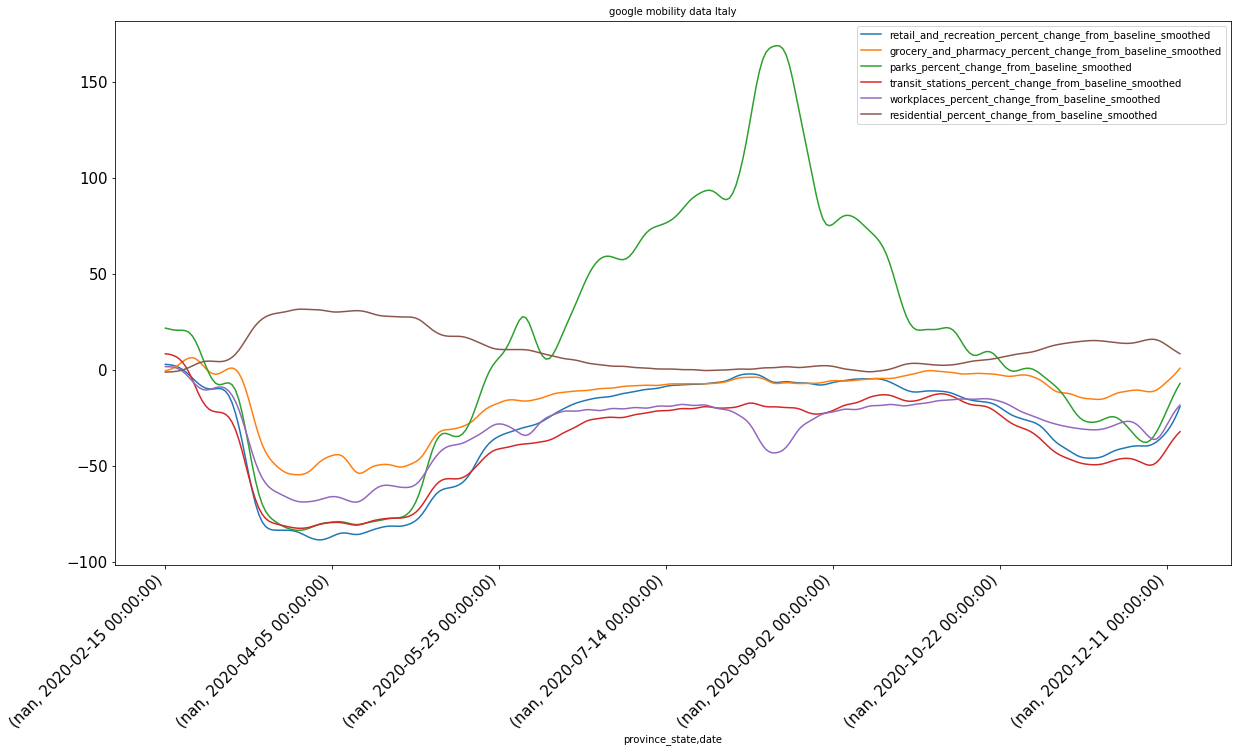

In [22]:
set_plot_fontsizes(10, 10, 10)
ax1 = italy.loc[:,[col for col in italy.columns if 'baseline_smoothed' in col]].plot(figsize=(20,10), fontsize=15, title='google mobility data Italy')
xt,_=plt.xticks(rotation=45, ha='right')


# Convert Lat Long from polar to cartesian

AI algs don't know about S1 and polar coordinates where standard euclidean metric does not hold ...

Let's convert the Lat Long system into a 3D euclidean one, the geocentric system.

In [23]:
metadata = pd.read_pickle(os.path.join(COMPUTED_PATH, METADATA_BASE_NAME.format(DATA_DATE)))

In [24]:
def lla_to_ecef(coordinates):
    # credits https://gis.stackexchange.com/questions/230160/converting-wgs84-to-ecef-in-python
    lat = np.radians(coordinates[:,0])
    lon = np.radians(coordinates[:,1])
    alt = coordinates[:,2]
    # see http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    #rad = np.float64(6378137.0)        # Radius of the Earth (in meters)
    rad = 1.        # Radius of the Earth: take 1 to normalize
    f = np.float64(1.0/298.257223563)  # Flattening factor WGS84 Model
    cosLat = np.cos(lat)
    sinLat = np.sin(lat)
    FF     = (1.0-f)**2
    C      = 1/np.sqrt(cosLat**2 + FF * sinLat**2)
    S      = C * FF

    # normalize to [0,1]
    x = ((rad * C + alt)*cosLat * np.cos(lon) + 1.) / 2.
    y = ((rad * C + alt)*cosLat * np.sin(lon) + 1.) / 2.
    z = ((rad * S + alt)*sinLat + 1.) / 2.
    return np.dstack([x, y, z])[0]

In [25]:
geocentric = lla_to_ecef(np.insert(metadata.loc[:,['Lat','Long']].to_numpy(),2,0, axis=1))
metadata['x'] = geocentric[:,0]
metadata['y'] = geocentric[:,1]
metadata['z'] = geocentric[:,2]

# merge covid mobility data with metadata

In [26]:
# convert np.nan into strings as merge is not happy with strings and nan together

preprocessing.index = pd.MultiIndex.from_tuples(
    [tuple('nan' if pd.isna(l) else l for l in ix) for ix in preprocessing.index.to_list()],
    names=['country_region', 'province_state', 'date']
)
metadata.index = pd.MultiIndex.from_tuples(
    [tuple('nan' if pd.isna(l) else l for l in ix) for ix in metadata.index.to_list()],
    names=['country_region', 'province_state']
)


preprocessing = preprocessing.merge(
    metadata.loc[:,['population_estimate_2016', 'x', 'y', 'z']], 
    left_index=True, right_index=True
)

# get the np.nan back istead of strings
preprocessing.index = pd.MultiIndex.from_tuples(
    [tuple(np.nan if l=='nan' else l for l in ix) for ix in preprocessing.index.to_list()],
    names=['country_region', 'province_state', 'date']
)

In [27]:
preprocessing.reset_index(inplace=True)
preprocessing.set_index(['country_state', 'date'],inplace=True)

In [28]:
preprocessing

country_region province_state  \
country_state date                                       
Angola        2020-02-15         Angola            NaN   
              2020-02-16         Angola            NaN   
              2020-02-17         Angola            NaN   
              2020-02-18         Angola            NaN   
              2020-02-19         Angola            NaN   
...                                 ...            ...   
Zimbabwe      2020-12-11       Zimbabwe            NaN   
              2020-12-12       Zimbabwe            NaN   
              2020-12-13       Zimbabwe            NaN   
              2020-12-14       Zimbabwe            NaN   
              2020-12-15       Zimbabwe            NaN   

                          retail_and_recreation_percent_change_from_baseline  \
country_state date                                                             
Angola        2020-02-15                                                3.0    
              2020-02-16                                               -4.0    
              2020-02-17                                               -6.0    
              2020-02-18                                               -3.0    
              2020-02-19                                              -10.0    
...                                                                     ...    
Zimbabwe      2020-12-11                                               12.0    
              2020-12-12                                               12.0    
              2020-12-13                                               11.0    
              2020-12-14                                                8.0    
              2020-12-15                                               10.0    

                          grocery_and_pharmacy_percent_change_from_baseline  \
country_state date                                                            
Angola        2020-02-15                                               -2.0   
              2020-02-16                                                0.0   
              2020-02-17                                               -4.0   
              2020-02-18                                               -4.0   
              2020-02-19                                              -12.0   
...                                                                     ...   
Zimbabwe      2020-12-11                                               28.0   
              2020-12-12                                               26.0   
              2020-12-13                                               23.0   
              2020-12-14                                               20.0   
              2020-12-15                                               27.0   

                          parks_percent_change_from_baseline  \
country_state date                                             
Angola        2020-02-15                                 7.0   
              2020-02-16                               -11.0   
              2020-02-17                                 2.0   
              2020-02-18                                -4.0   
              2020-02-19                                -3.0   
...                                                      ...   
Zimbabwe      2020-12-11                                29.0   
              2020-12-12                                33.0   
              2020-12-13                                41.0   
              2020-12-14                                29.0   
              2020-12-15                                28.0   

                          transit_stations_percent_change_from_baseline  \
country_state date                                                        
Angola        2020-02-15                                            3.0   
              2020-02-16                                            1.0   
              2020-02-17                                           -

## normalize confirmed_new and deaths_new

In [29]:
preprocessing['confirmed_new_smoothed_norm'] = preprocessing.confirmed_new_smoothed / preprocessing.population_estimate_2016
preprocessing['deaths_new_smoothed_norm'] = preprocessing.deaths_new_smoothed / preprocessing.population_estimate_2016

preprocessing['confirmed_norm'] = preprocessing.confirmed / preprocessing.population_estimate_2016
preprocessing['deaths_norm'] = preprocessing.deaths / preprocessing.population_estimate_2016

# save preprocessing data

In [30]:
preprocessing.to_pickle(os.path.join(COMPUTED_PATH, WORLDWIDE_PREPROC_NAME.format(DATA_DATE)))

## plot Italy and NY

In [31]:
italy = preprocessing.loc['Italy']

In [32]:
set_plot_fontsizes(10, 10, 10)

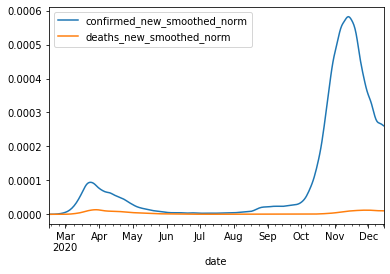

In [33]:
italy.loc[:,['confirmed_new_smoothed_norm','deaths_new_smoothed_norm']].plot()

In [34]:
ny = preprocessing.loc['United States - New York']

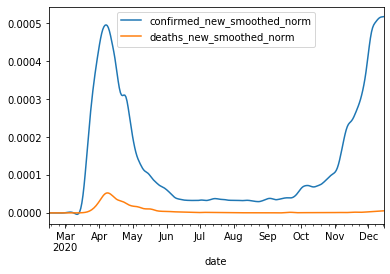

In [35]:
ny.loc[:,['confirmed_new_smoothed_norm','deaths_new_smoothed_norm']].plot()

## compare new cases worldwide, taking the max of the curve

In [36]:
preprocessing.loc[:,['confirmed_new_smoothed_norm']]

confirmed_new_smoothed_norm
country_state date                                   
Angola        2020-02-15                 1.132414e-12
              2020-02-16                 2.756319e-12
              2020-02-17                 4.231188e-12
              2020-02-18                 4.917960e-12
              2020-02-19                 4.216695e-12
...                                               ...
Zimbabwe      2020-12-11                 5.459768e-06
              2020-12-12                 5.350702e-06
              2020-12-13                 5.389175e-06
              2020-12-14                 5.532302e-06
              2020-12-15                 5.716522e-06

[51240 rows x 1 columns]

In [37]:
max_confirmed_norm = preprocessing.loc[:,['confirmed_new_smoothed_norm']].groupby(
    by='country_state').apply(max)['confirmed_new_smoothed_norm'].reset_index().sort_values(
    by='confirmed_new_smoothed_norm', ascending=False
)

In [38]:
max_confirmed_norm[max_confirmed_norm.country_state=='Italy']

,country_state,confirmed_new_smoothed_norm
61,Italy,0.000582


In [39]:
max_confirmed_norm_filt = max_confirmed_norm[max_confirmed_norm.confirmed_new_smoothed_norm>0.00008]

In [40]:
set_plot_fontsizes(22, 30, 50)

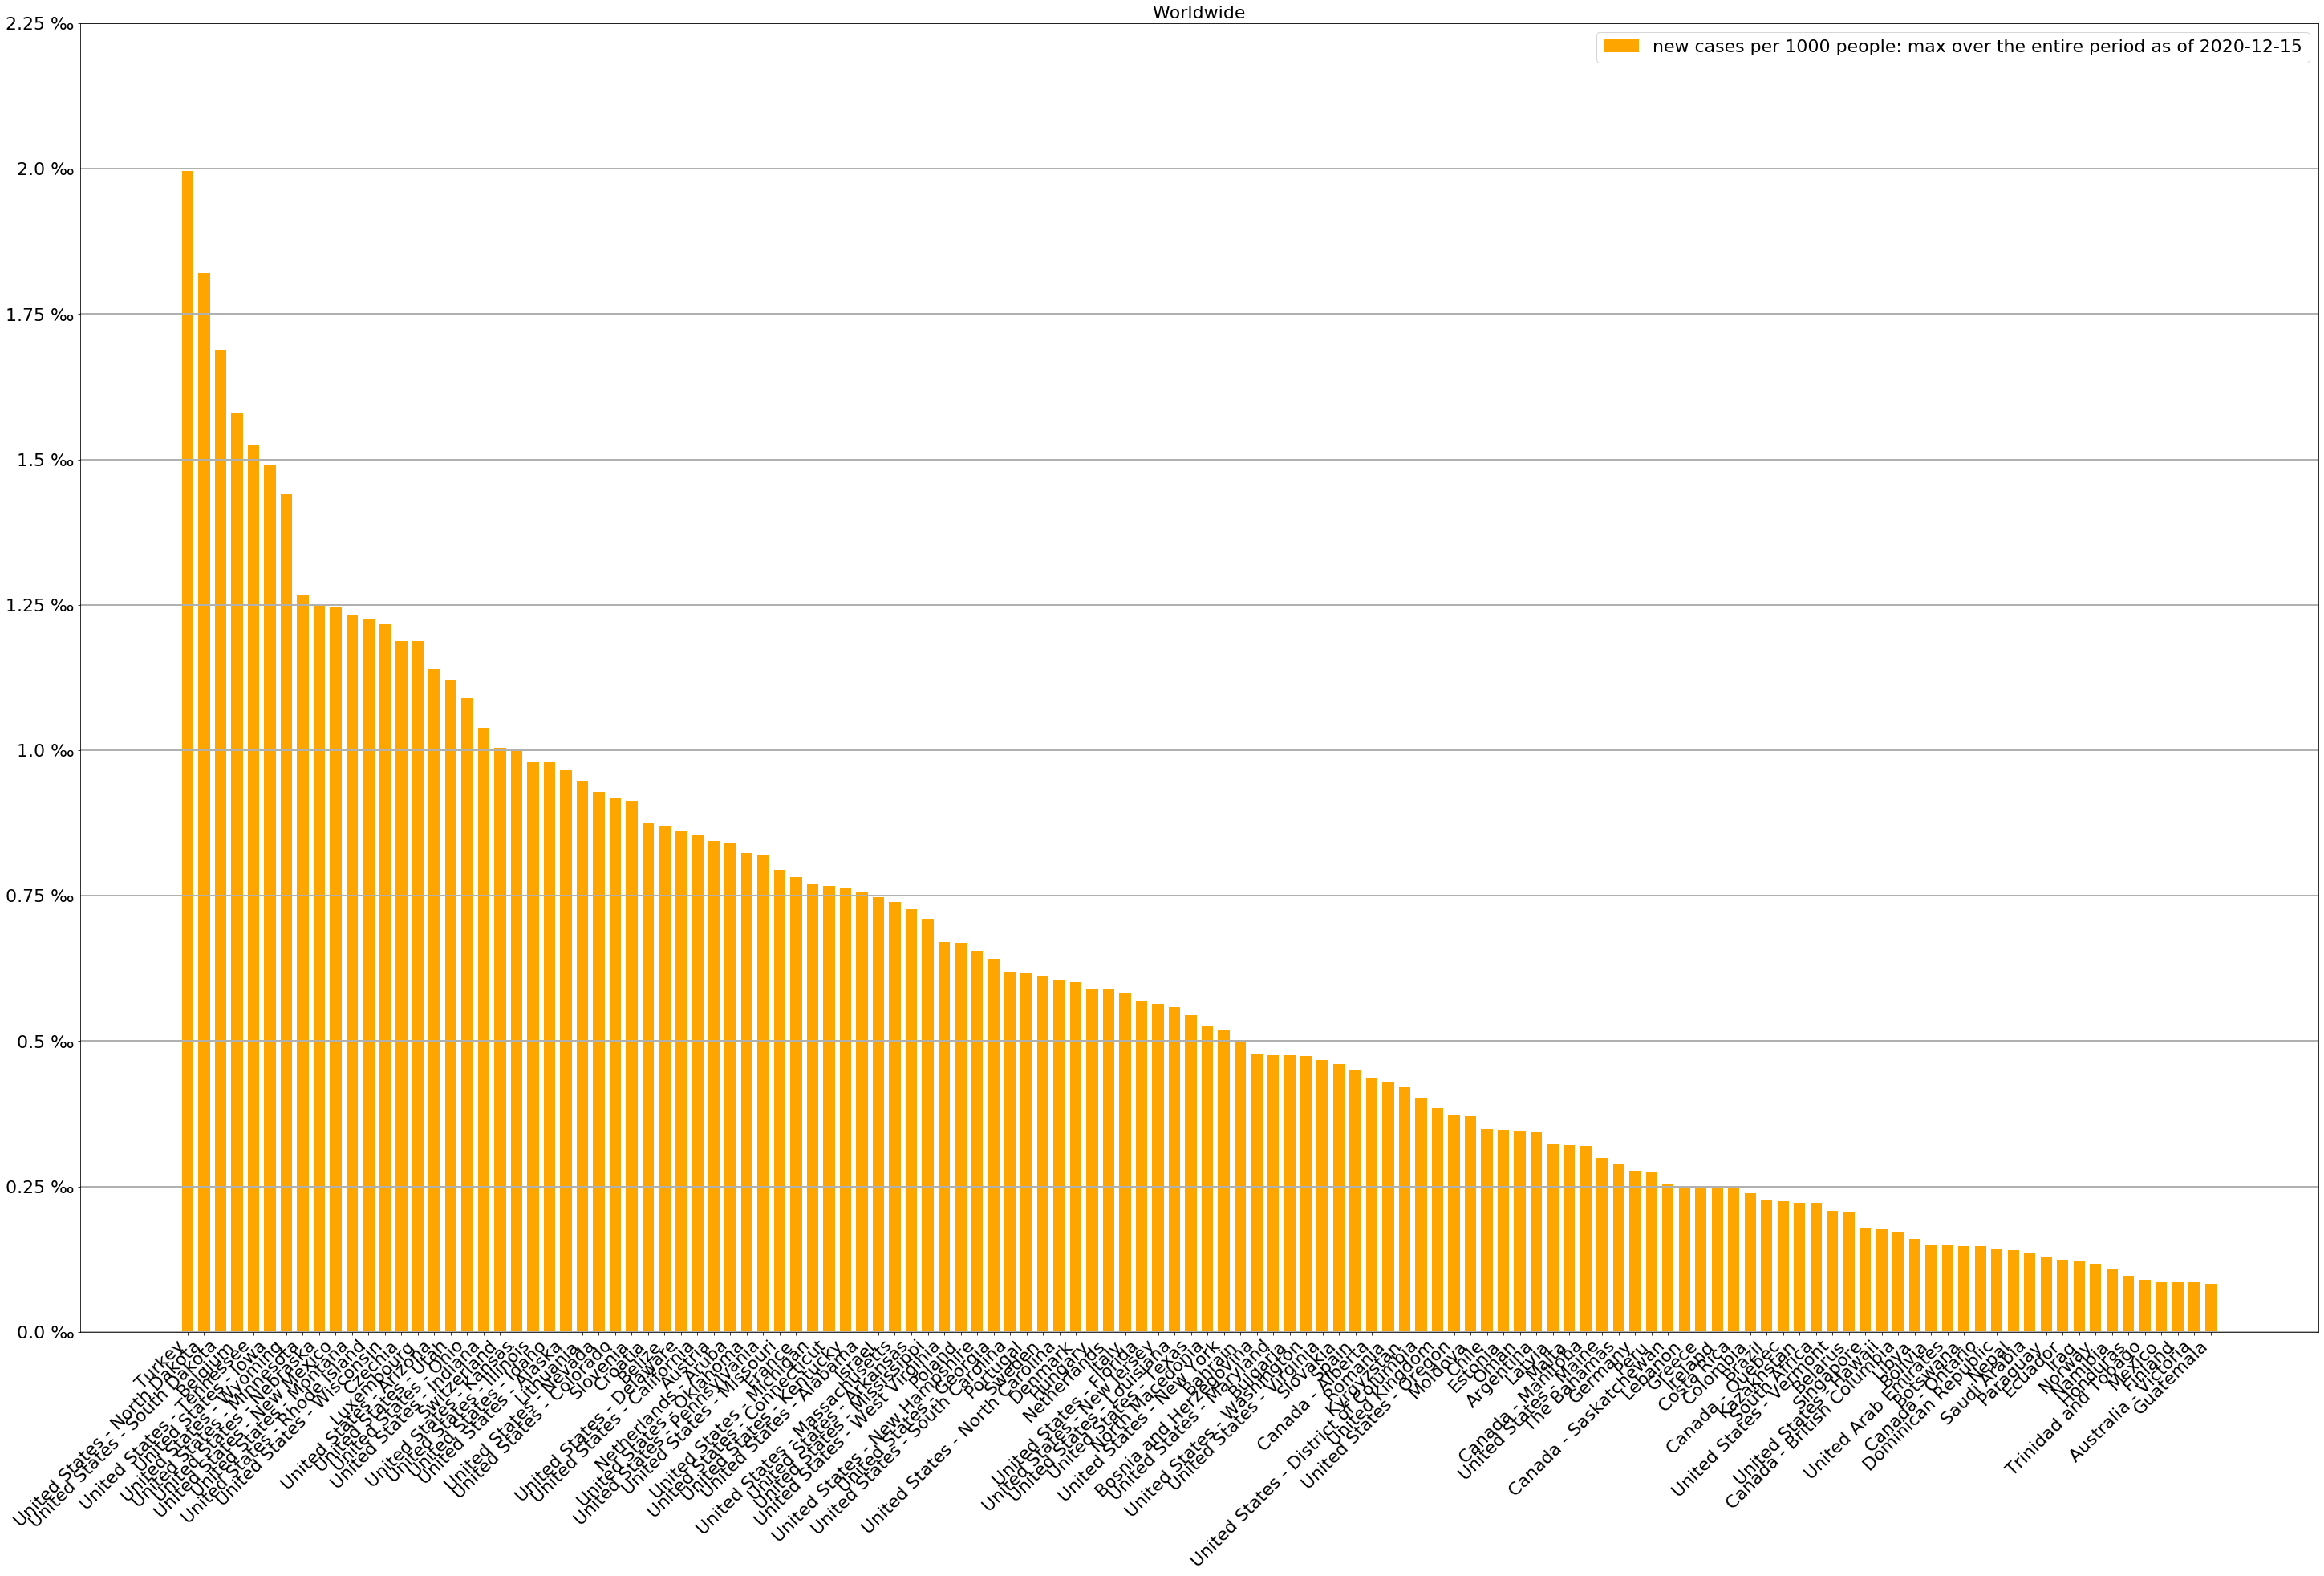

In [41]:
plt.figure(figsize=(50,30))
plt.bar(max_confirmed_norm_filt.country_state, max_confirmed_norm_filt.confirmed_new_smoothed_norm, align='center', width=0.7, color='orange')
a=plt.xticks(rotation=45, ha='right')
yt,_=plt.yticks()
lbt=map(lambda t: str(t)+' ‰', np.round(yt*1000,2))
yt,_=plt.yticks(yt, lbt)
title = plt.title('Worldwide')
leg = plt.legend(['new cases per 1000 people: max over the entire period as of {}'.format(DATA_DATE)])
plt.grid(axis='y', linewidth=2)
plt.savefig(os.path.join(IMAGES_PATH,MAX_NEW_CASES.format(DATA_DATE)))

In [42]:
most_recent_df = preprocessing[
    preprocessing.index.get_level_values('date')==preprocessing.index.get_level_values('date').max()
].reset_index().sort_values(by='confirmed_norm', ascending=False)

In [43]:
most_recent_high = most_recent_df[most_recent_df.confirmed_norm>0.0025]

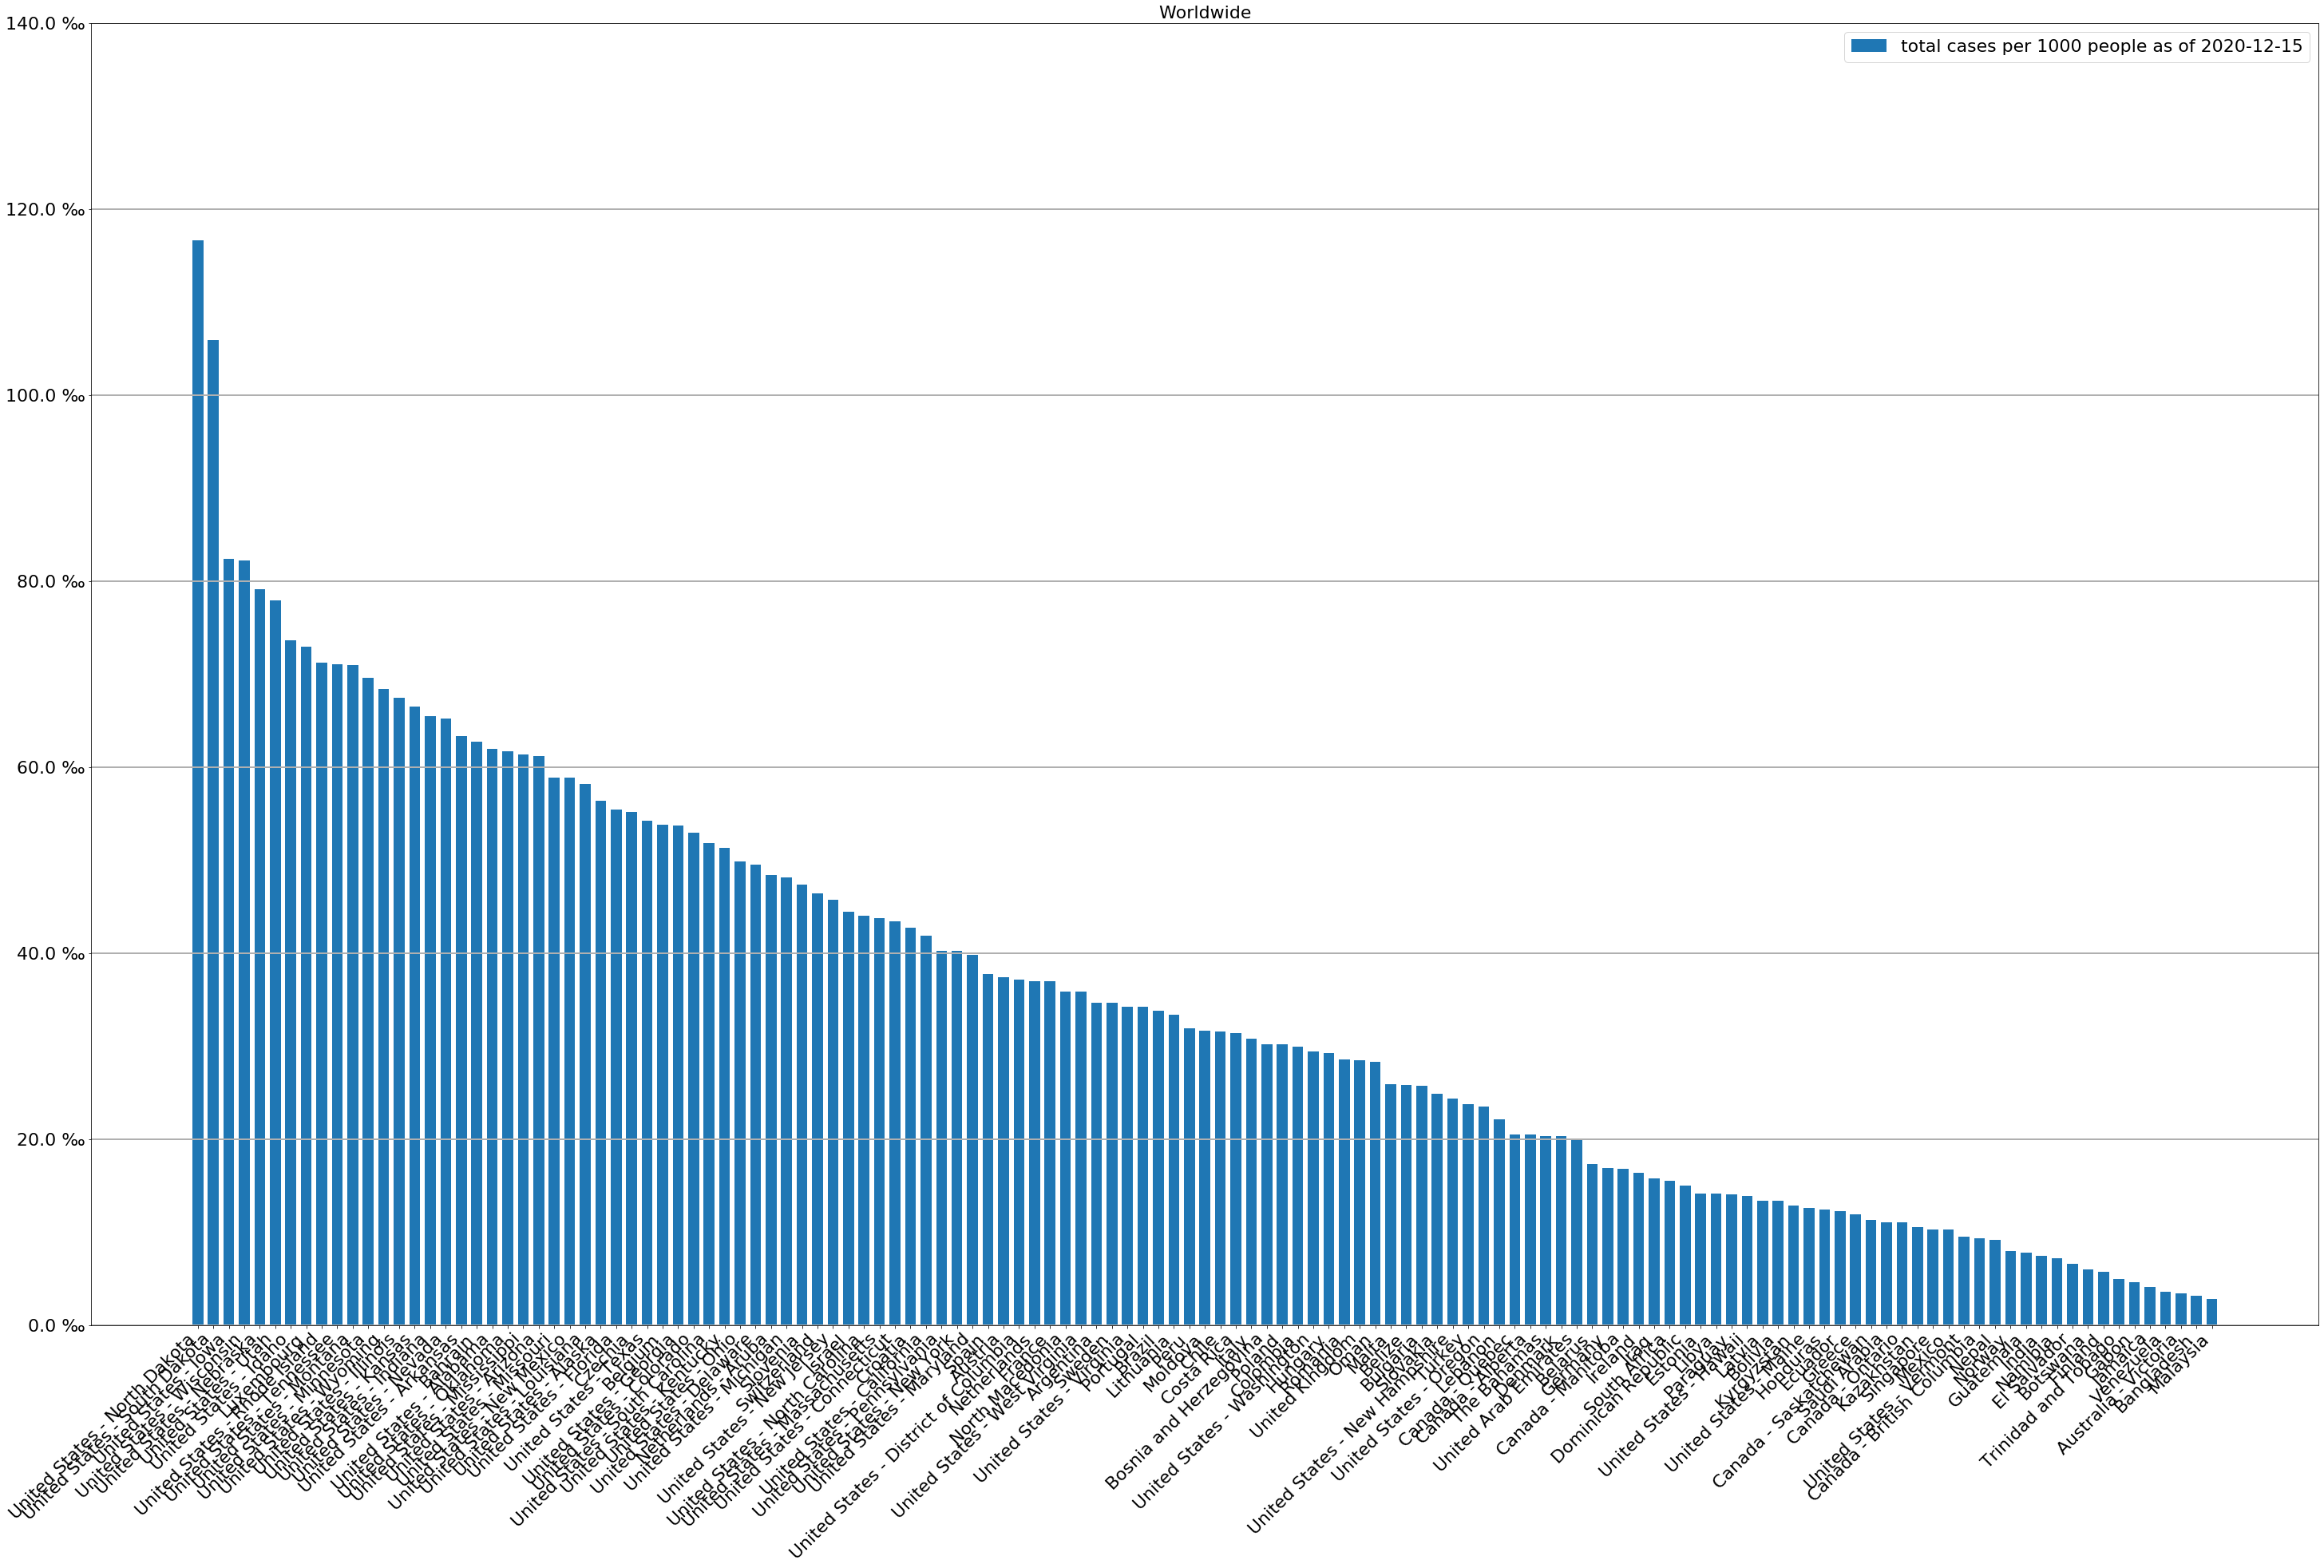

In [44]:
plt.figure(figsize=(50,30))
plt.bar(most_recent_high.country_state, most_recent_high.confirmed_norm, align='center', width=0.7)
a=plt.xticks(rotation=45, ha='right')
yt,_=plt.yticks()
lbt=map(lambda t: str(t)+' ‰', yt*1000)
yt,_=plt.yticks(yt, lbt)
title = plt.title('Worldwide')
leg = plt.legend(['total cases per 1000 people as of {}'.format(DATA_DATE)])
plt.grid(axis='y', linewidth=2)
plt.savefig(os.path.join(IMAGES_PATH,TOTAL_CASES.format(DATA_DATE)))

In [45]:
most_recent_df.loc[most_recent_df.country_state=='Italy','confirmed_norm']*1000

61    30.835499
Name: confirmed_norm, dtype: float64

# Get a 3D numpy array

- first dimension: country_state
- second dimension: time
- third dimension: numeric features

In [46]:
features = (
    ['x','y','z'] +
    [c for c in preprocessing.columns if 'baseline_smoothed' in c or 'smoothed_norm' in c]
)

In [47]:
CONFIRMED_NEW_CASES_SMOOTHED_FEATURE = features.index('confirmed_new_smoothed_norm')

In [48]:
CONFIRMED_NEW_CASES_SMOOTHED_FEATURE

9

In [49]:
covid_mobility_series = preprocessing.loc[:,features].values.reshape(
    len(preprocessing.index.levels[0]),
    len(preprocessing.index.levels[1]),
    -1
)

In [50]:
covid_mobility_series.shape

(168, 305, 11)

### just store the index of Italy within the 3D array

In [51]:
def get_countrystate_index(pdf, countrystate):
    return list(pdf.index.levels[0]).index(countrystate)

In [52]:
italy_index = get_countrystate_index(preprocessing, 'Italy')

# Normalize data

In [53]:
scaler = MinMaxScaler()

### We scale the features on a cross-region basis, as we later want to train each model at once on multi-region data

1. reshape the array to a 2D matrix, with regions and time on the same axis, 
2. rescale it
3. reshape it back to the original 3D axis

In [54]:
covid_mobility_series_scaled = scaler.fit_transform(
    covid_mobility_series.reshape(
        covid_mobility_series.shape[0]*covid_mobility_series.shape[1], 
        covid_mobility_series.shape[2]
    )
).reshape(
    covid_mobility_series.shape[0],
    covid_mobility_series.shape[1],
    covid_mobility_series.shape[2]
)

### persist the scaler for later inverse transform

In [55]:
with open(os.path.join(COMPUTED_PATH, 'minmaxscaler_{}.pickle'.format(DATA_DATE)), 'bw') as f:
    pickle.dump(scaler, f)

### test the persisted scaler inverse transform versus original data

In [56]:
with open(os.path.join(COMPUTED_PATH, 'minmaxscaler_{}.pickle'.format(DATA_DATE)), 'br') as f:
    scaler = pickle.load(f)
    
italy_restored = scaler.inverse_transform(covid_mobility_series_scaled[italy_index,:,:])

In [57]:
assert(
    np.log(italy_restored[:,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE].max()) - 
    np.log(covid_mobility_series[italy_index,:,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE].max()) 
    == 0
)

# Create input/target shifted series

In [58]:
LOOK_BACK = 14
LOOK_AHEAD = 7

In [59]:
def running_view(arr, window, shift=1, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] = int((shape[axis] - window) / shift) + 1
    strides = list(arr.strides)
    strides = strides + [strides[axis]]
    strides[axis] = strides[axis]*shift
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        strides)

In [60]:
covid_mobility_series_scaled_running = running_view(
    covid_mobility_series_scaled, 
    LOOK_BACK + LOOK_AHEAD, 
    axis=1)

In [61]:
covid_mobility_series_scaled_running.shape

(168, 285, 11, 21)

- axis 0: country/states
- axis 1: time
- axis 2: features
- axis 3: time segments of length LOOK_BACK + LOOK_AHEAD

### Visually test Italy running view:

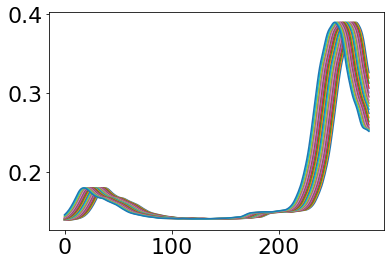

In [62]:
p = plt.plot(covid_mobility_series_scaled_running[italy_index, :,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE,:])

## Check the existence of leading zeros in the first segment of each country/state

We need to be sure that the first segment (of length LOOK_BACK) of each Country/State is not fully ZERO, as this would be interpreted by the model as **the virus emerging from "nothing"**

Some zeros do exists:

In [63]:
(covid_mobility_series_scaled[:,:,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE] == 0).any()

True

There are no "all zeros in the first segment" of any Country/State raw:

In [64]:
assert(
    not (
        covid_mobility_series_scaled_running[:,0,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE,:LOOK_BACK] ==
        np.zeros((covid_mobility_series_scaled_running.shape[0], LOOK_BACK))
    ).any()
)

## Create input/target features

### Input

We take every feature as input, limiting the running segments length to the first `LOOK_BACK`

In [65]:
X = covid_mobility_series_scaled_running[:,:,:,:LOOK_BACK]

In [66]:
X.shape

(168, 285, 11, 14)

### Targets

We take as target the feature `CONFIRMED_NEW_CASES_SMOOTHED_FEATURE`, limiting the running segments length to the last `LOOK_AHEAD`

In [67]:
Y = covid_mobility_series_scaled_running[:,:,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE, LOOK_BACK:]

In [68]:
Y.shape

(168, 285, 7)

# Split training / test historically

In [69]:
TEST_HIST_RATIO = 0.2

TRAIN_HIST_SIZE = int(X.shape[1]*(1-TEST_HIST_RATIO))

In [70]:
X_hist_train, X_hist_test = \
    X[:,:TRAIN_HIST_SIZE,:,:], X[:,TRAIN_HIST_SIZE:,:,:]

Y_hist_train, Y_hist_test = \
    Y[:,:TRAIN_HIST_SIZE,:], Y[:,TRAIN_HIST_SIZE:,:]

In [71]:
X_hist_train.shape, X_hist_test.shape, Y_hist_train.shape, Y_hist_test.shape

((168, 228, 11, 14), (168, 57, 11, 14), (168, 228, 7), (168, 57, 7))

In [72]:
np.savez_compressed(
    os.path.join(COMPUTED_PATH, 'hist-model-arrays_{}'.format(DATA_DATE)), 
    X_hist_train=X_hist_train, 
    X_hist_test=X_hist_test, 
    Y_hist_train=Y_hist_train, 
    Y_hist_test=Y_hist_test
)

# Split training / test geographically

In [73]:
TEST_GEO_RATIO = 0.2

### Sample a random set of country/states + Italy :)

In [74]:
np.random.seed(1234)
TEST_COUNTRYSTATE_INDEXES = np.append(
    np.random.choice(X.shape[0], int(X.shape[0]*TEST_GEO_RATIO), replace=False), 
    get_countrystate_index(preprocessing, 'Italy')
)

TEST_COUNTRYSTATE_INDEXES_BOOL = np.array(np.zeros(X.shape[0]), dtype=bool)
TEST_COUNTRYSTATE_INDEXES_BOOL[TEST_COUNTRYSTATE_INDEXES] = True

In [75]:
def get_countrystate_by_index(pdf, index):
    return pdf.index.levels[0][index]

In [76]:
assert(get_countrystate_by_index(preprocessing, get_countrystate_index(preprocessing,'Italy')) == 'Italy')

### ok, which country/states are in the testset??

In [77]:
get_countrystate_by_index(preprocessing, TEST_COUNTRYSTATE_INDEXES_BOOL)

Index(['Australia - South Australia', 'Australia - Western Australia',
       'Cameroon', 'Canada - British Columbia', 'Canada - New Brunswick',
       'Canada - Ontario', 'Cote d'Ivoire', 'Croatia', 'Finland', 'Germany',
       'Honduras', 'Ireland', 'Italy', 'Japan', 'Latvia', 'Mauritius',
       'Mexico', 'Mozambique', 'Romania', 'Rwanda', 'Saudi Arabia',
       'Switzerland', 'Taiwan', 'United Arab Emirates',
       'United States - Florida', 'United States - Idaho',
       'United States - Illinois', 'United States - Kansas',
       'United States - Louisiana', 'United States - Maine',
       'United States - Michigan', 'United States - New Hampshire',
       'United States - Utah', 'United States - Wyoming'],
      dtype='object', name='country_state')

In [78]:
# get the complement of TEST_COUNTRYSTATE_INDEXES:

TRAIN_COUNTRYSTATE_INDEXES_BOOL = np.array(np.ones(X.shape[0]), dtype=bool)
TRAIN_COUNTRYSTATE_INDEXES_BOOL[TEST_COUNTRYSTATE_INDEXES] = False

In [79]:
X_geo_train, X_geo_test = X[TRAIN_COUNTRYSTATE_INDEXES_BOOL], X[TEST_COUNTRYSTATE_INDEXES_BOOL]
Y_geo_train, Y_geo_test = Y[TRAIN_COUNTRYSTATE_INDEXES_BOOL], Y[TEST_COUNTRYSTATE_INDEXES_BOOL]

X_geo_train.shape, X_geo_test.shape, Y_geo_train.shape, Y_geo_test.shape

((134, 285, 11, 14), (34, 285, 11, 14), (134, 285, 7), (34, 285, 7))

In [80]:
np.savez_compressed(
    os.path.join(COMPUTED_PATH, 'geo-model-arrays_{}'.format(DATA_DATE)), 
    X_geo_train=X_geo_train, 
    X_geo_test=X_geo_test, 
    Y_geo_train=Y_geo_train, 
    Y_geo_test=Y_geo_test,
    TRAIN_COUNTRYSTATE_INDEXES_BOOL=TRAIN_COUNTRYSTATE_INDEXES_BOOL,
    TEST_COUNTRYSTATE_INDEXES_BOOL=TEST_COUNTRYSTATE_INDEXES_BOOL
)

## Country/states lookups

In [81]:
def get_train_test_country_index(pdf, train_index_bool, test_index_bool, countrystate):
    train = get_countrystate_by_index(pdf, train_index_bool) == countrystate
    if train.any():
        return np.where(train)[0][0]
    else:
        test = get_countrystate_by_index(pdf, test_index_bool) == countrystate
        if test.any():
            return np.where(test)[0][0]
        else:
            return None

### Check that we can get the country/states from the correct train and test sets:

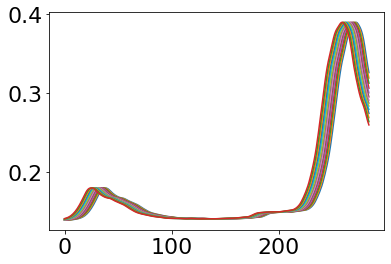

In [82]:
# Italy from the testset:

p = plt.plot(
    X_geo_test[get_train_test_country_index(
        preprocessing, 
        TRAIN_COUNTRYSTATE_INDEXES_BOOL, 
        TEST_COUNTRYSTATE_INDEXES_BOOL, 
        'Italy'
    ),:,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE,:]
)

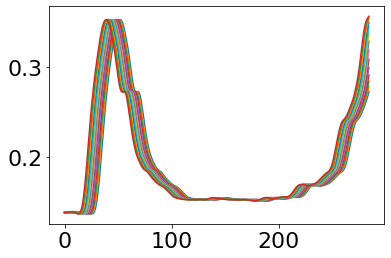

In [83]:
# New York from the trainset

p = plt.plot(
    X_geo_train[get_train_test_country_index(
        preprocessing, 
        TRAIN_COUNTRYSTATE_INDEXES_BOOL, 
        TEST_COUNTRYSTATE_INDEXES_BOOL, 
        'United States - New York'
    ),:,CONFIRMED_NEW_CASES_SMOOTHED_FEATURE,:]
)